![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
plt.style.use('fivethirtyeight')

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [3]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [4]:
epidemic_duration_in_days = 365

Tamanho da população.

In [5]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [6]:
initially_infected = 52

Onde está a pasta base que contém os dados?

In [7]:
data_folder = '../data/'

Qual coluna dos dados históricos reais devemos usar para ajustar os parâmetros dos modelos?

In [8]:
data_column_to_fit = 'total_cases_ESTIMATED'

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [9]:
target_location = 'Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [10]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [11]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [12]:
results_suffix = ''

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [13]:
# custom papermill parameters

In [14]:
# Parameters
target_location = "South Korea"
infer_parameters_from_data = True
results_suffix = ".south korea"


## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [15]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    df_simulated_data = df_simulated_data[['S', 'E', 'I', 'R', 'E+I', 'E+I+R']]
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data)
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']])
    ax.set_title('Apenas Expostos e Infectados')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    if zoom_on is not None:
        zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
        ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']][zoom_on:zoom_end], markers=True)
        if file_name is not None:
            ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
        ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
        plt.figure()

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [16]:
df_epidemy_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')
df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,countriesAndTerritories,continent,population_year,population
0,2019-12-31,Afghanistan,0,0,0,0,Afghanistan,Asia,2020.0,38928341.0
1,2020-01-01,Afghanistan,0,0,0,0,Afghanistan,Asia,2020.0,38928341.0


Selecionemos apenas dados sobre o país de interesse.

In [17]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,countriesAndTerritories,continent,population_year,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2
date,,,,,,,,,,
2020-04-03,86,5,10062,174,South_Korea,Asia,2020.0,51269183.0,NaN,100620
2020-04-04,94,3,10156,177,South_Korea,Asia,2020.0,51269183.0,NaN,101560
2020-04-05,81,6,10237,183,South_Korea,Asia,2020.0,51269183.0,NaN,102370
2020-04-06,47,3,10284,186,South_Korea,Asia,2020.0,51269183.0,NaN,102840
2020-04-07,47,6,10331,192,South_Korea,Asia,2020.0,51269183.0,NaN,103310


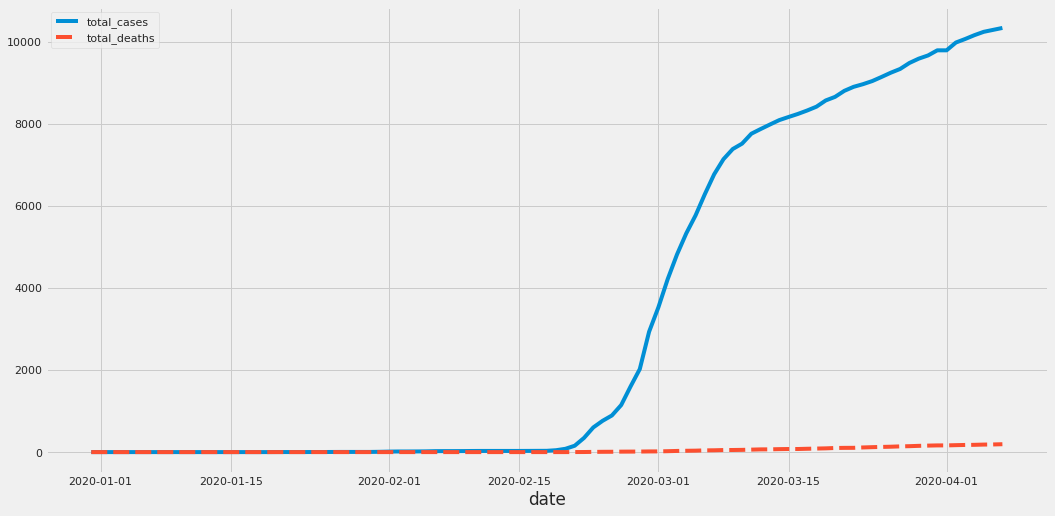

In [18]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 10 * df_data_target['total_cases']

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [19]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-02-20 00:00:00')

In [20]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-02-20 00:00:00, population_size=51269183.0, initially_infected=80


Filtremos os dados a partir da data de interesse.

In [21]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [22]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [23]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [24]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    min_length = int(min_length)
    for value, length in regimens:
        length = int(length)
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [25]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [26]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [27]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [28]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [29]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [30]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

In [31]:
# how many new patients will be added to R
def r_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_r = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta_r

### Simulação

A simulação então pode ser definida do seguinte modo.

In [32]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func, r_delta_func):
    
    generated_data = [] # initial data
    
    # changes start at 0
    E_delta = 0
    I_delta = 0 
    R_delta = 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R, R_delta))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)
        R_delta = r_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R', 'R_delta'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    df['E+I+R'] = df['E'] + df['I'] + df['R']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [33]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-02-20,5.126910e+07,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000,80.000000
2020-02-21,5.126910e+07,8.000000,0.000000,72.000000,72.000000,0.000000,0.000000,80.000000,80.000000
2020-02-22,5.126905e+07,58.399910,57.599910,57.600000,7.200000,21.600000,21.600000,115.999910,137.599910
2020-02-23,5.126900e+07,51.919867,46.079876,92.879919,52.559919,38.880000,17.280000,144.799786,183.679786
2020-02-24,5.126893e+07,79.495656,74.303669,111.743824,46.727881,66.743976,27.863976,191.239480,257.983456


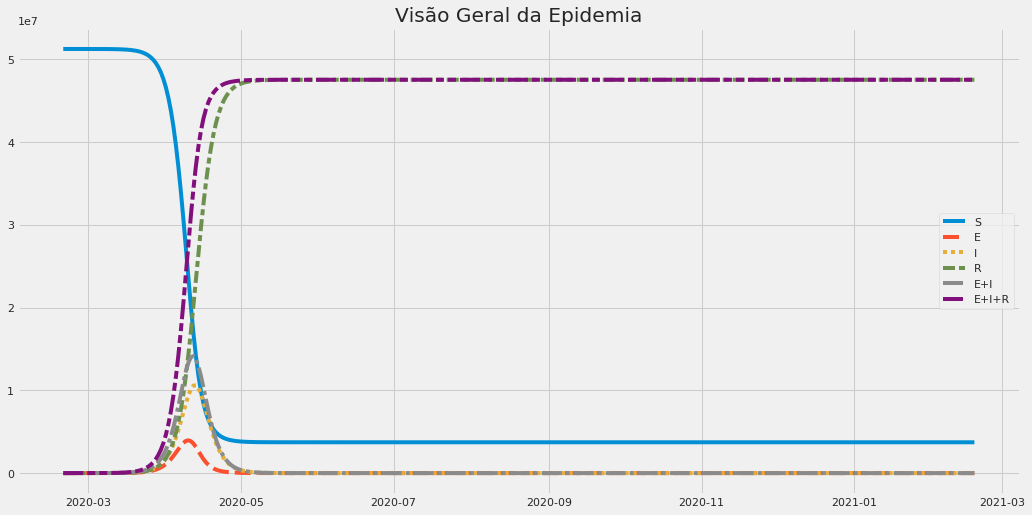

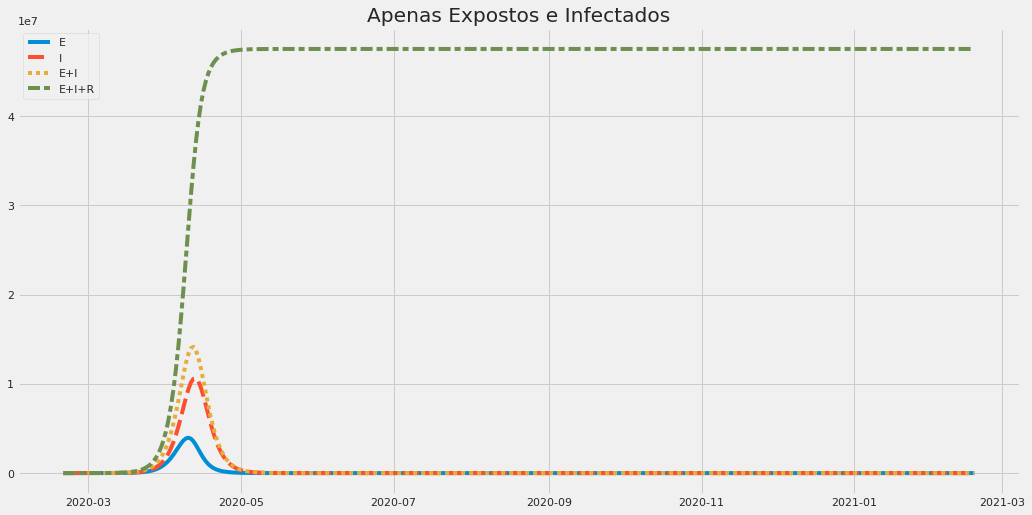

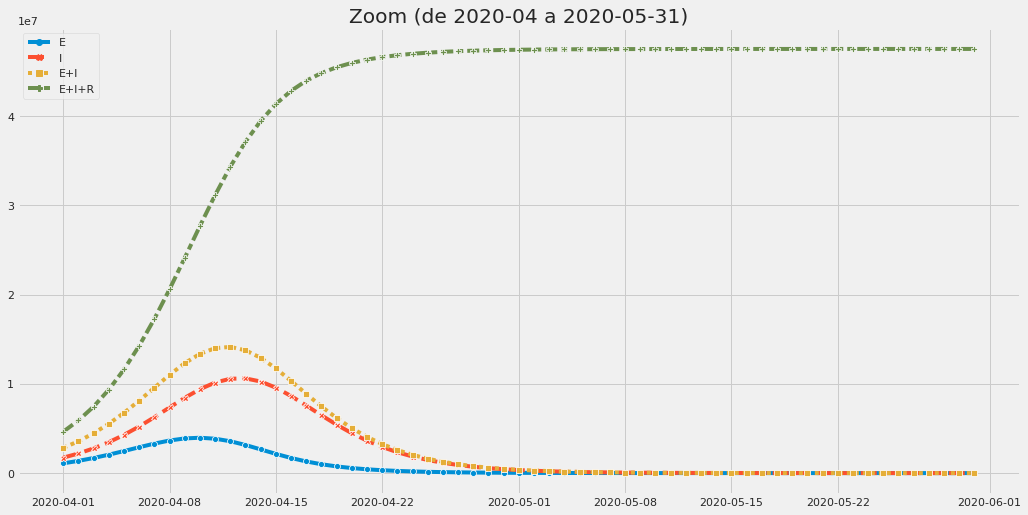

<Figure size 1152x576 with 0 Axes>

In [34]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

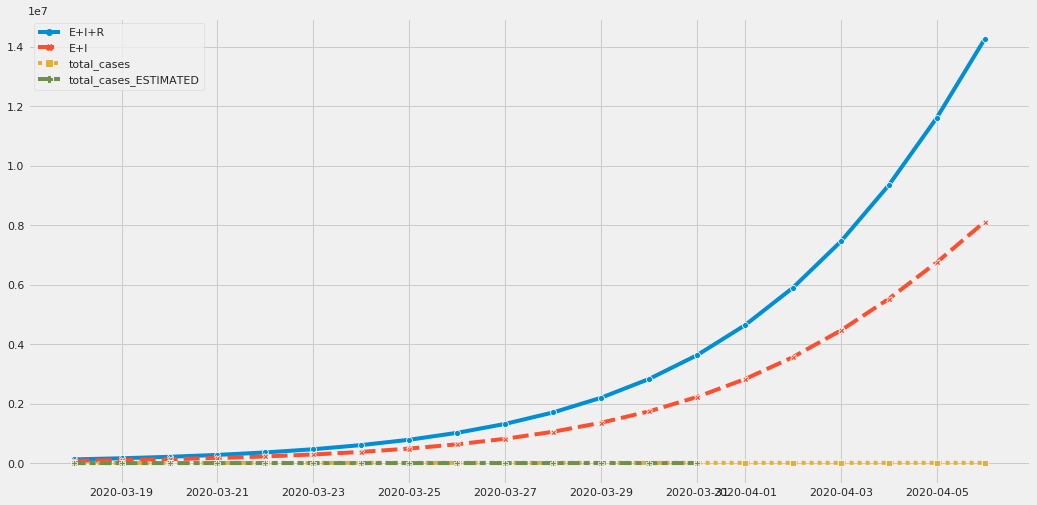

In [35]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [36]:
beta = dynamic_parameter([(0.3, 30), 
                          (0.1, 60), 
                          (0.05, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)


,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-02-20,5.126910e+07,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000,80.000000
2020-02-21,5.126910e+07,8.000000,0.000000,72.000000,72.000000,0.000000,0.000000,80.000000,80.000000
2020-02-22,5.126908e+07,22.399966,21.599966,57.600000,7.200000,21.600000,21.600000,79.999966,101.599966
2020-02-23,5.126906e+07,19.519962,17.279966,60.479970,20.159970,38.880000,17.280000,79.999932,118.879932
2020-02-24,5.126905e+07,20.095945,18.143949,59.903945,17.567966,57.023991,18.143991,79.999890,137.023881


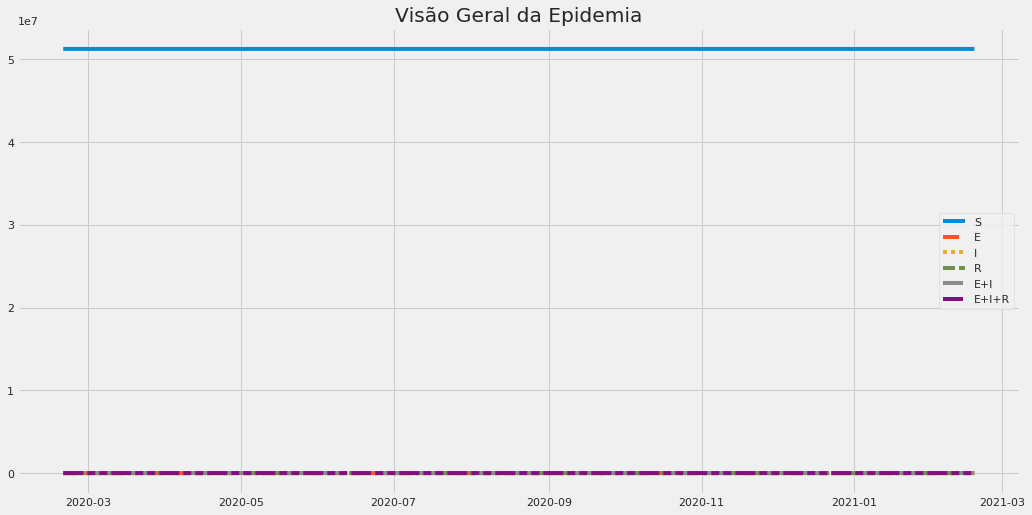

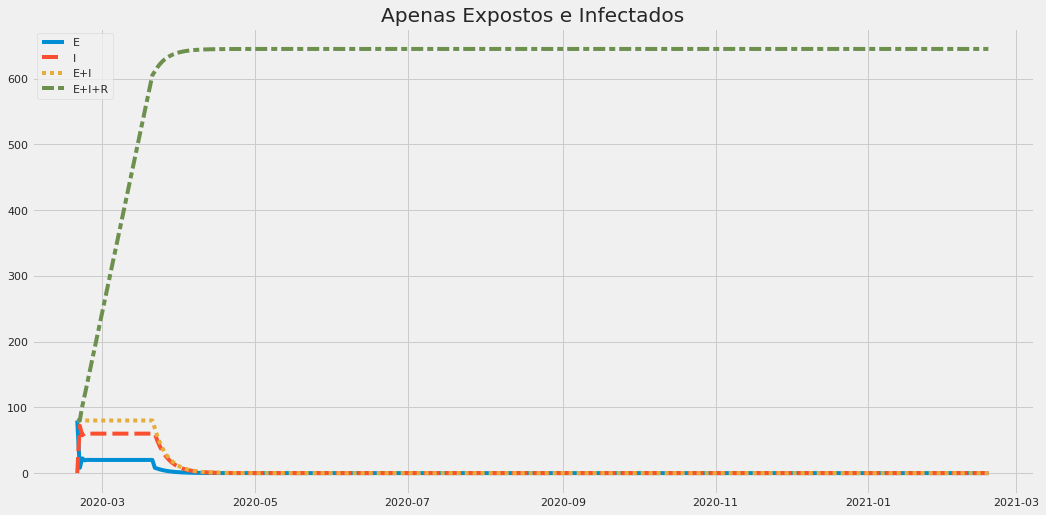

<Figure size 1152x576 with 0 Axes>

In [37]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [38]:
def objective_for_simulation(args):
    ##################################################################
    # What kind of parameters we are optimizing? Constant or dynamic?
    ##################################################################
    if 'constant' in args:
        alpha, beta, gamma, t_min, t_max = args['constant']
    elif 'dynamic' in args:
        params_sets, t_min, t_max = args['dynamic'] # TODO
        alpha = []
        beta = []
        gamma = []
        for params in params_sets:
            alpha.append((params['alpha'], int(params['duration'])))
            beta.append((params['beta'], int(params['duration'])))
            gamma.append((params['gamma'], int(params['duration'])))
        
        alpha = dynamic_parameter(alpha, min_length=epidemic_duration_in_days)
        beta = dynamic_parameter(beta, min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter(gamma, min_length=epidemic_duration_in_days)
        
    ###########
    # Simulate
    ###########
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    ###################
    # Calculate error
    ###################
    df_diff_cases = df_data_target[data_column_to_fit] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'] + df_simulation_data_filtered['R'])
    
    # we can limit the temporal reach of the estimation if desired
    if t_min is not None and t_max is not None:
        df_diff_cases = df_diff_cases.iloc[t_min:t_max] 
    
    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [39]:
#space = {'constant': (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}
space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=300, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/300 [00:00<?, ?trial/s, best loss=?]

  2%|▏         | 7/300 [00:00<00:04, 64.45trial/s, best loss: 1047.9935906438304]

  4%|▎         | 11/300 [00:00<00:05, 50.37trial/s, best loss: 653.0669054534974]

  5%|▌         | 16/300 [00:00<00:05, 49.11trial/s, best loss: 562.3881306557539]

  7%|▋         | 22/300 [00:00<00:05, 50.71trial/s, best loss: 562.3881306557539]

  9%|▉         | 27/300 [00:00<00:05, 48.11trial/s, best loss: 562.3881306557539]

 11%|█         | 32/300 [00:00<00:05, 46.21trial/s, best loss: 562.3881306557539]

 12%|█▏        | 37/300 [00:00<00:05, 44.79trial/s, best loss: 562.3881306557539]

 14%|█▍        | 42/300 [00:00<00:05, 44.10trial/s, best loss: 562.3881306557539]

 16%|█▌        | 47/300 [00:01<00:05, 43.26trial/s, best loss: 562.3881306557539]

 17%|█▋        | 52/300 [00:01<00:05, 43.02trial/s, best loss: 444.9903371121216]

 19%|█▉        | 57/300 [00:01<00:05, 42.97trial/s, best loss: 444.9903371121216]

 21%|██        | 62/300 [00:01<00:05, 42.97trial/s, best loss: 444.9903371121216]

 22%|██▏       | 67/300 [00:01<00:05, 42.91trial/s, best loss: 444.9903371121216]

 24%|██▍       | 72/300 [00:01<00:05, 42.96trial/s, best loss: 444.9903371121216]

 26%|██▌       | 77/300 [00:01<00:05, 42.95trial/s, best loss: 444.4113177132104]

 27%|██▋       | 82/300 [00:01<00:05, 42.93trial/s, best loss: 401.4411313589498]

 29%|██▉       | 87/300 [00:01<00:05, 42.55trial/s, best loss: 401.4411313589498]

 31%|███       | 92/300 [00:02<00:04, 42.54trial/s, best loss: 401.4411313589498]

 32%|███▏      | 97/300 [00:02<00:04, 41.95trial/s, best loss: 401.4411313589498]

 34%|███▍      | 102/300 [00:02<00:04, 42.06trial/s, best loss: 401.4411313589498]

 36%|███▌      | 107/300 [00:02<00:04, 42.22trial/s, best loss: 401.4411313589498]

 37%|███▋      | 112/300 [00:02<00:04, 42.24trial/s, best loss: 401.4411313589498]

 39%|███▉      | 117/300 [00:02<00:04, 41.90trial/s, best loss: 401.4411313589498]

 41%|████      | 122/300 [00:02<00:04, 41.72trial/s, best loss: 401.4411313589498]

 42%|████▏     | 127/300 [00:02<00:04, 40.81trial/s, best loss: 401.4411313589498]

 44%|████▍     | 132/300 [00:03<00:04, 40.19trial/s, best loss: 401.4411313589498]

 46%|████▌     | 137/300 [00:03<00:04, 40.37trial/s, best loss: 401.4411313589498]

 47%|████▋     | 142/300 [00:03<00:03, 40.33trial/s, best loss: 401.4411313589498]

 49%|████▉     | 147/300 [00:03<00:03, 40.34trial/s, best loss: 401.4411313589498]

 51%|█████     | 152/300 [00:03<00:03, 40.25trial/s, best loss: 401.4411313589498]

 52%|█████▏    | 157/300 [00:03<00:03, 40.06trial/s, best loss: 401.4411313589498]

 54%|█████▍    | 162/300 [00:03<00:03, 40.27trial/s, best loss: 401.4411313589498]

 56%|█████▌    | 167/300 [00:03<00:03, 40.30trial/s, best loss: 401.4411313589498]

 57%|█████▋    | 172/300 [00:04<00:03, 40.41trial/s, best loss: 401.4411313589498]

 59%|█████▉    | 177/300 [00:04<00:03, 40.40trial/s, best loss: 401.4411313589498]

 61%|██████    | 182/300 [00:04<00:02, 40.47trial/s, best loss: 401.4411313589498]

 62%|██████▏   | 187/300 [00:04<00:02, 40.45trial/s, best loss: 401.4411313589498]

 64%|██████▍   | 192/300 [00:04<00:02, 40.29trial/s, best loss: 401.4411313589498]

 66%|██████▌   | 197/300 [00:04<00:02, 40.17trial/s, best loss: 401.4411313589498]

 67%|██████▋   | 202/300 [00:04<00:02, 39.97trial/s, best loss: 401.4411313589498]

 69%|██████▊   | 206/300 [00:04<00:02, 39.95trial/s, best loss: 401.4411313589498]

 70%|███████   | 210/300 [00:05<00:02, 39.92trial/s, best loss: 401.4411313589498]

 71%|███████▏  | 214/300 [00:05<00:02, 39.75trial/s, best loss: 401.4411313589498]

 73%|███████▎  | 218/300 [00:05<00:02, 39.39trial/s, best loss: 401.4411313589498]

 74%|███████▍  | 222/300 [00:05<00:01, 39.03trial/s, best loss: 401.4411313589498]

 75%|███████▌  | 226/300 [00:05<00:01, 38.87trial/s, best loss: 401.4411313589498]

 77%|███████▋  | 230/300 [00:05<00:01, 38.83trial/s, best loss: 401.4411313589498]

 78%|███████▊  | 234/300 [00:05<00:01, 38.83trial/s, best loss: 401.4411313589498]

 79%|███████▉  | 238/300 [00:05<00:01, 38.75trial/s, best loss: 401.4411313589498]

 81%|████████  | 242/300 [00:05<00:01, 37.78trial/s, best loss: 401.4411313589498]

 82%|████████▏ | 246/300 [00:05<00:01, 35.72trial/s, best loss: 401.4411313589498]

 83%|████████▎ | 250/300 [00:06<00:01, 36.59trial/s, best loss: 401.4411313589498]

 85%|████████▍ | 254/300 [00:06<00:01, 37.21trial/s, best loss: 401.4411313589498]

 86%|████████▌ | 258/300 [00:06<00:01, 37.63trial/s, best loss: 401.4411313589498]

 87%|████████▋ | 262/300 [00:06<00:01, 37.79trial/s, best loss: 401.4411313589498]

 89%|████████▊ | 266/300 [00:06<00:01, 32.39trial/s, best loss: 401.4411313589498]

 90%|█████████ | 270/300 [00:06<00:00, 33.88trial/s, best loss: 401.4411313589498]

 91%|█████████▏| 274/300 [00:06<00:00, 35.01trial/s, best loss: 401.4411313589498]

 93%|█████████▎| 278/300 [00:06<00:00, 35.84trial/s, best loss: 401.4411313589498]

 94%|█████████▍| 282/300 [00:06<00:00, 36.53trial/s, best loss: 401.4411313589498]

 95%|█████████▌| 286/300 [00:07<00:00, 37.11trial/s, best loss: 401.4411313589498]

 97%|█████████▋| 290/300 [00:07<00:00, 37.44trial/s, best loss: 401.4411313589498]

 98%|█████████▊| 294/300 [00:07<00:00, 37.68trial/s, best loss: 388.6159894911999]

 99%|█████████▉| 298/300 [00:07<00:00, 37.75trial/s, best loss: 388.6159894911999]

100%|██████████| 300/300 [00:07<00:00, 40.28trial/s, best loss: 388.6159894911999]


Best parameters found: {'alpha': 0.9976793537187689, 'beta': 0.9092444960640309, 'gamma': 0.8258404685571847}


In [40]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-16,5.126744e+07,106.942061,106.698258,125.252079,104.814110,1507.257737,96.914027,232.194140,1739.451877
2020-03-17,5.126733e+07,114.129074,113.880899,128.507729,106.693886,1610.695973,103.438235,242.636803,1853.332776
2020-03-18,5.126721e+07,117.105575,116.840722,136.245067,113.864221,1716.822856,106.126883,253.350642,1970.173498
2020-03-19,5.126709e+07,124.147077,123.875317,140.562191,116.833814,1829.339546,112.516690,264.709269,2094.048815
2020-03-20,5.126696e+07,128.088280,127.800179,148.339221,123.858976,1945.421492,116.081946,276.427501,2221.848993


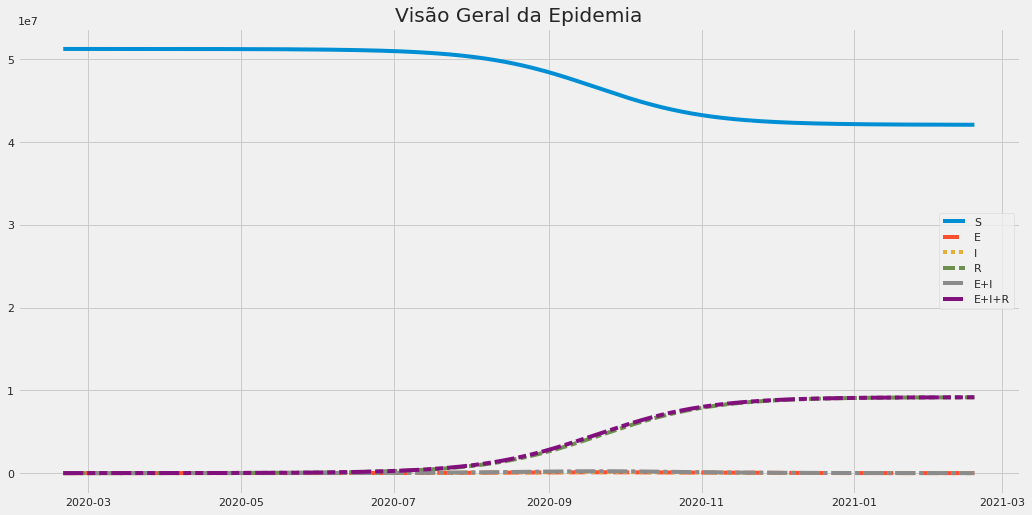

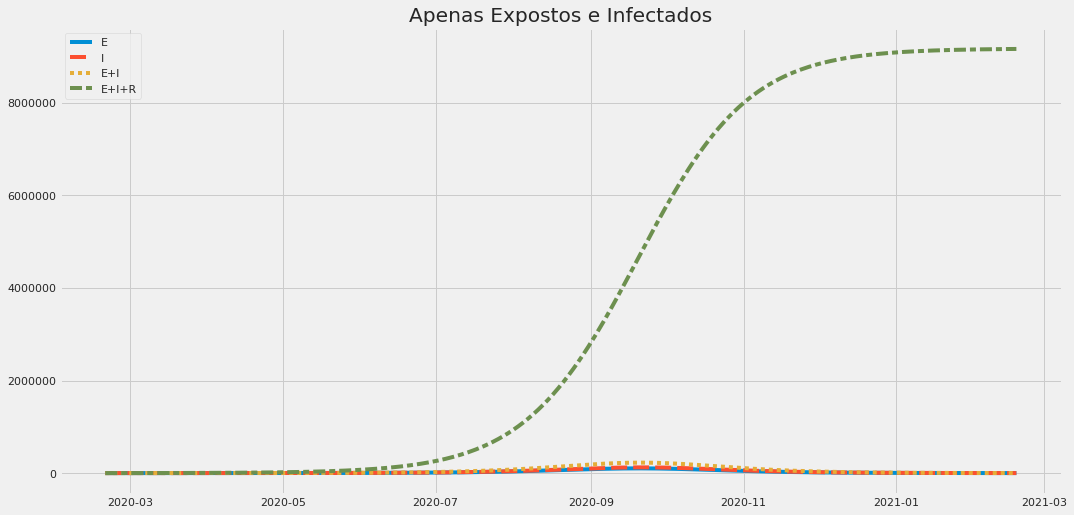

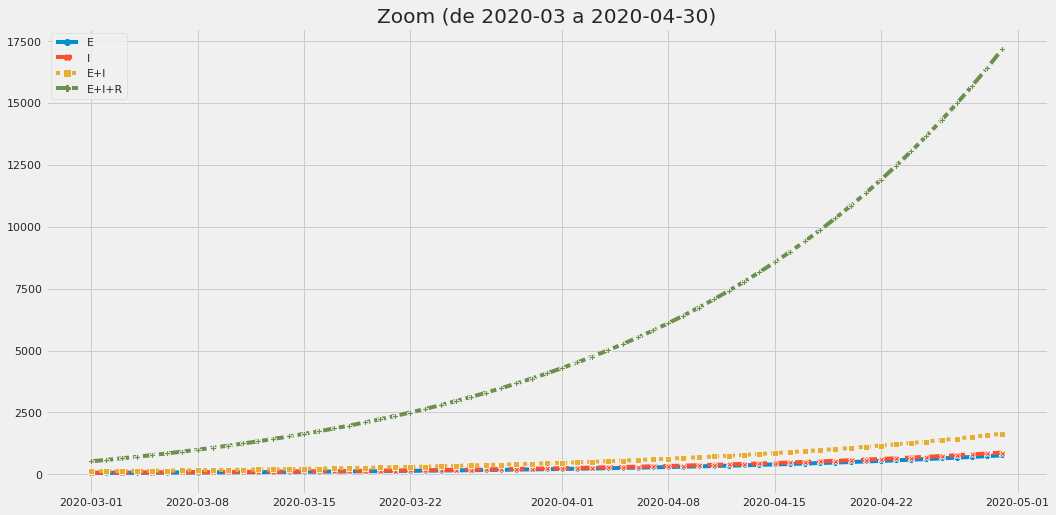

<Figure size 1152x576 with 0 Axes>

In [41]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-03', file_name='constant')
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [42]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,countriesAndTerritories,continent,population_year,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2
date,,,,,,,,,,
2020-04-03,86,5,10062,174,South_Korea,Asia,2020.0,51269183.0,NaN,100620
2020-04-04,94,3,10156,177,South_Korea,Asia,2020.0,51269183.0,NaN,101560
2020-04-05,81,6,10237,183,South_Korea,Asia,2020.0,51269183.0,NaN,102370
2020-04-06,47,3,10284,186,South_Korea,Asia,2020.0,51269183.0,NaN,102840
2020-04-07,47,6,10331,192,South_Korea,Asia,2020.0,51269183.0,NaN,103310


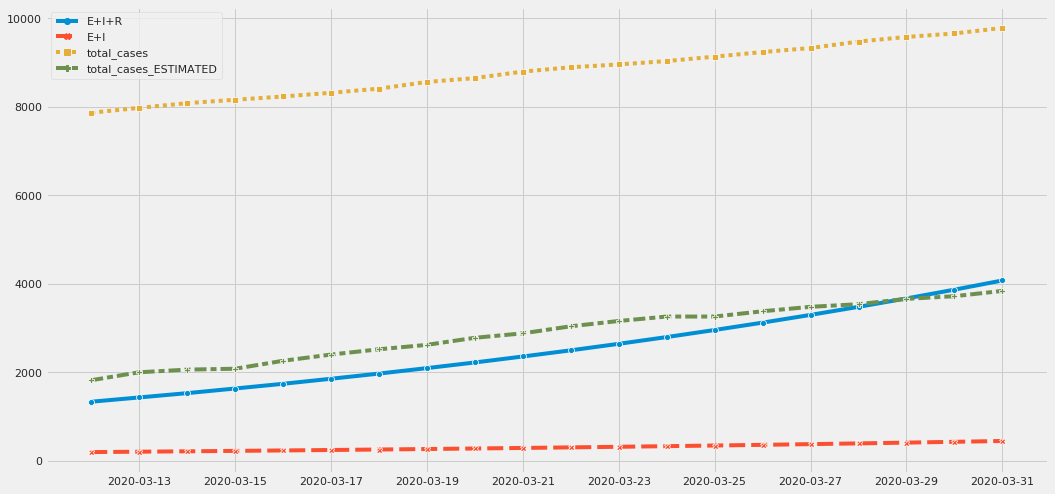

In [43]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Salvemos os resultados.

In [44]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo a possibilidade de aprender medidas de mitigação após o início do surto. Ou seja, experimentaremos com dois grupos de parâmetros: aqueles *antes* das medidas, e aqueles *depois* das medidas. Esses dois conjuntos de parâmetros serão estimados a partir dos dados fornecidos.

In [45]:
space = \
    {'dynamic':\
        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.0, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_1', 10.0, 30.0)}, 
           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.0, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_2', 0.0, 30.0)}], 
        0, None)
    }

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1500, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/1500 [00:00<?, ?trial/s, best loss=?]

  0%|          | 6/1500 [00:00<00:26, 56.50trial/s, best loss: 798.9612659333696]

  1%|          | 12/1500 [00:00<00:26, 56.44trial/s, best loss: 798.9612659333696]

  1%|          | 18/1500 [00:00<00:26, 56.40trial/s, best loss: 798.9612659333696]

  1%|▏         | 22/1500 [00:00<00:30, 48.32trial/s, best loss: 733.2766082234574]

  2%|▏         | 26/1500 [00:00<00:38, 38.41trial/s, best loss: 733.2766082234574]

  2%|▏         | 30/1500 [00:00<00:44, 33.34trial/s, best loss: 438.54227397614346]

  2%|▏         | 34/1500 [00:00<00:47, 30.59trial/s, best loss: 438.54227397614346]

  2%|▏         | 37/1500 [00:01<00:51, 28.64trial/s, best loss: 438.54227397614346]

  3%|▎         | 40/1500 [00:01<00:53, 27.13trial/s, best loss: 438.54227397614346]

  3%|▎         | 43/1500 [00:01<00:54, 26.49trial/s, best loss: 438.54227397614346]

  3%|▎         | 46/1500 [00:01<00:55, 26.11trial/s, best loss: 388.3871986107778] 

  3%|▎         | 49/1500 [00:01<00:56, 25.77trial/s, best loss: 388.3871986107778]

  3%|▎         | 52/1500 [00:01<00:56, 25.45trial/s, best loss: 388.3871986107778]

  4%|▎         | 55/1500 [00:01<00:57, 25.23trial/s, best loss: 388.3871986107778]

  4%|▍         | 58/1500 [00:01<00:57, 25.15trial/s, best loss: 388.3871986107778]

  4%|▍         | 61/1500 [00:01<00:57, 24.96trial/s, best loss: 388.3871986107778]

  4%|▍         | 64/1500 [00:02<00:58, 24.61trial/s, best loss: 388.3871986107778]

  4%|▍         | 67/1500 [00:02<01:00, 23.85trial/s, best loss: 388.3871986107778]

  5%|▍         | 70/1500 [00:02<01:00, 23.81trial/s, best loss: 360.86573744548485]

  5%|▍         | 73/1500 [00:02<00:59, 24.07trial/s, best loss: 360.86573744548485]

  5%|▌         | 76/1500 [00:02<00:58, 24.33trial/s, best loss: 360.86573744548485]

  5%|▌         | 79/1500 [00:02<00:58, 24.49trial/s, best loss: 360.86573744548485]

  5%|▌         | 82/1500 [00:02<00:58, 24.42trial/s, best loss: 360.86573744548485]

  6%|▌         | 85/1500 [00:02<00:58, 24.29trial/s, best loss: 360.86573744548485]

  6%|▌         | 88/1500 [00:03<01:07, 20.92trial/s, best loss: 360.86573744548485]

  6%|▌         | 91/1500 [00:03<01:04, 21.87trial/s, best loss: 360.86573744548485]

  6%|▋         | 94/1500 [00:03<01:02, 22.58trial/s, best loss: 360.86573744548485]

  6%|▋         | 97/1500 [00:03<01:00, 23.02trial/s, best loss: 360.86573744548485]

  7%|▋         | 100/1500 [00:03<01:00, 23.21trial/s, best loss: 360.86573744548485]

  7%|▋         | 103/1500 [00:03<00:59, 23.40trial/s, best loss: 360.86573744548485]

  7%|▋         | 106/1500 [00:03<00:59, 23.42trial/s, best loss: 360.86573744548485]

  7%|▋         | 109/1500 [00:04<00:59, 23.46trial/s, best loss: 360.86573744548485]

  7%|▋         | 112/1500 [00:04<00:59, 23.50trial/s, best loss: 218.13457561019072]

  8%|▊         | 115/1500 [00:04<00:58, 23.58trial/s, best loss: 218.13457561019072]

  8%|▊         | 118/1500 [00:04<00:59, 23.41trial/s, best loss: 218.13457561019072]

  8%|▊         | 121/1500 [00:04<00:59, 23.31trial/s, best loss: 218.13457561019072]

  8%|▊         | 124/1500 [00:04<00:59, 23.20trial/s, best loss: 218.13457561019072]

  8%|▊         | 127/1500 [00:04<00:59, 23.06trial/s, best loss: 177.49870032053468]

  9%|▊         | 130/1500 [00:04<00:59, 23.05trial/s, best loss: 177.49870032053468]

  9%|▉         | 133/1500 [00:05<01:00, 22.55trial/s, best loss: 177.49870032053468]

  9%|▉         | 136/1500 [00:05<01:00, 22.62trial/s, best loss: 177.49870032053468]

  9%|▉         | 139/1500 [00:05<00:59, 22.76trial/s, best loss: 177.49870032053468]

  9%|▉         | 142/1500 [00:05<00:59, 22.78trial/s, best loss: 177.49870032053468]

 10%|▉         | 145/1500 [00:05<00:59, 22.58trial/s, best loss: 177.49870032053468]

 10%|▉         | 148/1500 [00:05<00:59, 22.59trial/s, best loss: 177.49870032053468]

 10%|█         | 151/1500 [00:05<00:59, 22.54trial/s, best loss: 177.49870032053468]

 10%|█         | 154/1500 [00:06<00:59, 22.61trial/s, best loss: 177.49870032053468]

 10%|█         | 157/1500 [00:06<00:59, 22.53trial/s, best loss: 177.49870032053468]

 11%|█         | 160/1500 [00:06<00:59, 22.58trial/s, best loss: 177.49870032053468]

 11%|█         | 163/1500 [00:06<00:59, 22.57trial/s, best loss: 177.49870032053468]

 11%|█         | 166/1500 [00:06<00:59, 22.47trial/s, best loss: 177.49870032053468]

 11%|█▏        | 169/1500 [00:06<00:58, 22.61trial/s, best loss: 177.49870032053468]

 11%|█▏        | 172/1500 [00:06<00:58, 22.73trial/s, best loss: 177.49870032053468]

 12%|█▏        | 175/1500 [00:06<00:58, 22.72trial/s, best loss: 177.49870032053468]

 12%|█▏        | 178/1500 [00:07<00:58, 22.56trial/s, best loss: 177.49870032053468]

 12%|█▏        | 181/1500 [00:07<00:58, 22.63trial/s, best loss: 122.08338036711295]

 12%|█▏        | 184/1500 [00:07<00:58, 22.54trial/s, best loss: 122.08338036711295]

 12%|█▏        | 187/1500 [00:07<00:58, 22.57trial/s, best loss: 122.08338036711295]

 13%|█▎        | 190/1500 [00:07<00:57, 22.62trial/s, best loss: 122.08338036711295]

 13%|█▎        | 193/1500 [00:07<00:57, 22.55trial/s, best loss: 122.08338036711295]

 13%|█▎        | 196/1500 [00:07<00:58, 22.36trial/s, best loss: 122.08338036711295]

 13%|█▎        | 199/1500 [00:08<00:58, 22.34trial/s, best loss: 122.08338036711295]

 13%|█▎        | 202/1500 [00:08<00:58, 22.20trial/s, best loss: 122.08338036711295]

 14%|█▎        | 205/1500 [00:08<00:58, 22.05trial/s, best loss: 122.08338036711295]

 14%|█▍        | 208/1500 [00:08<00:58, 22.07trial/s, best loss: 122.08338036711295]

 14%|█▍        | 211/1500 [00:08<00:58, 22.02trial/s, best loss: 122.08338036711295]

 14%|█▍        | 214/1500 [00:08<00:58, 22.00trial/s, best loss: 122.08338036711295]

 14%|█▍        | 217/1500 [00:08<00:58, 21.91trial/s, best loss: 122.08338036711295]

 15%|█▍        | 220/1500 [00:08<00:59, 21.63trial/s, best loss: 122.08338036711295]

 15%|█▍        | 223/1500 [00:09<00:59, 21.43trial/s, best loss: 122.08338036711295]

 15%|█▌        | 226/1500 [00:09<01:09, 18.42trial/s, best loss: 122.08338036711295]

 15%|█▌        | 229/1500 [00:09<01:06, 19.17trial/s, best loss: 122.08338036711295]

 15%|█▌        | 232/1500 [00:09<01:04, 19.72trial/s, best loss: 122.08338036711295]

 16%|█▌        | 235/1500 [00:09<01:02, 20.14trial/s, best loss: 122.08338036711295]

 16%|█▌        | 238/1500 [00:09<01:02, 20.28trial/s, best loss: 122.08338036711295]

 16%|█▌        | 241/1500 [00:10<01:01, 20.57trial/s, best loss: 122.08338036711295]

 16%|█▋        | 244/1500 [00:10<01:00, 20.79trial/s, best loss: 122.08338036711295]

 16%|█▋        | 247/1500 [00:10<01:00, 20.86trial/s, best loss: 122.08338036711295]

 17%|█▋        | 250/1500 [00:10<00:59, 20.95trial/s, best loss: 122.08338036711295]

 17%|█▋        | 253/1500 [00:10<00:59, 20.98trial/s, best loss: 122.08338036711295]

 17%|█▋        | 256/1500 [00:10<00:59, 20.92trial/s, best loss: 122.08338036711295]

 17%|█▋        | 259/1500 [00:10<00:59, 20.92trial/s, best loss: 122.08338036711295]

 17%|█▋        | 262/1500 [00:11<00:58, 21.04trial/s, best loss: 122.08338036711295]

 18%|█▊        | 265/1500 [00:11<00:58, 21.02trial/s, best loss: 122.08338036711295]

 18%|█▊        | 268/1500 [00:11<00:58, 21.00trial/s, best loss: 122.08338036711295]

 18%|█▊        | 271/1500 [00:11<00:58, 21.02trial/s, best loss: 122.08338036711295]

 18%|█▊        | 274/1500 [00:11<00:58, 21.00trial/s, best loss: 122.08338036711295]

 18%|█▊        | 277/1500 [00:11<00:58, 20.93trial/s, best loss: 122.08338036711295]

 19%|█▊        | 280/1500 [00:11<00:58, 20.81trial/s, best loss: 122.08338036711295]

 19%|█▉        | 283/1500 [00:12<00:58, 20.76trial/s, best loss: 122.08338036711295]

 19%|█▉        | 286/1500 [00:12<00:58, 20.81trial/s, best loss: 122.08338036711295]

 19%|█▉        | 289/1500 [00:12<00:58, 20.76trial/s, best loss: 122.08338036711295]

 19%|█▉        | 292/1500 [00:12<01:00, 19.87trial/s, best loss: 122.08338036711295]

 20%|█▉        | 295/1500 [00:12<01:00, 20.00trial/s, best loss: 122.08338036711295]

 20%|█▉        | 298/1500 [00:12<01:00, 19.95trial/s, best loss: 122.08338036711295]

 20%|██        | 301/1500 [00:12<00:59, 20.09trial/s, best loss: 122.08338036711295]

 20%|██        | 304/1500 [00:13<00:59, 20.21trial/s, best loss: 122.08338036711295]

 20%|██        | 307/1500 [00:13<00:59, 20.18trial/s, best loss: 122.08338036711295]

 21%|██        | 310/1500 [00:13<00:59, 19.90trial/s, best loss: 122.08338036711295]

 21%|██        | 313/1500 [00:13<00:59, 19.99trial/s, best loss: 122.08338036711295]

 21%|██        | 316/1500 [00:13<00:59, 20.02trial/s, best loss: 122.08338036711295]

 21%|██▏       | 319/1500 [00:13<00:58, 20.08trial/s, best loss: 122.08338036711295]

 21%|██▏       | 322/1500 [00:14<00:58, 20.07trial/s, best loss: 122.08338036711295]

 22%|██▏       | 325/1500 [00:14<00:58, 20.12trial/s, best loss: 122.08338036711295]

 22%|██▏       | 328/1500 [00:14<00:58, 20.15trial/s, best loss: 122.08338036711295]

 22%|██▏       | 331/1500 [00:14<00:58, 20.12trial/s, best loss: 122.08338036711295]

 22%|██▏       | 334/1500 [00:14<00:58, 20.06trial/s, best loss: 122.08338036711295]

 22%|██▏       | 337/1500 [00:14<00:58, 20.01trial/s, best loss: 122.08338036711295]

 23%|██▎       | 340/1500 [00:14<00:58, 19.90trial/s, best loss: 122.08338036711295]

 23%|██▎       | 342/1500 [00:15<00:58, 19.82trial/s, best loss: 122.08338036711295]

 23%|██▎       | 344/1500 [00:15<00:58, 19.69trial/s, best loss: 122.08338036711295]

 23%|██▎       | 346/1500 [00:15<00:58, 19.62trial/s, best loss: 122.08338036711295]

 23%|██▎       | 348/1500 [00:15<00:58, 19.64trial/s, best loss: 122.08338036711295]

 23%|██▎       | 350/1500 [00:15<00:58, 19.61trial/s, best loss: 122.08338036711295]

 23%|██▎       | 352/1500 [00:15<00:58, 19.58trial/s, best loss: 122.08338036711295]

 24%|██▎       | 354/1500 [00:15<00:58, 19.51trial/s, best loss: 122.08338036711295]

 24%|██▎       | 356/1500 [00:15<00:58, 19.42trial/s, best loss: 122.08338036711295]

 24%|██▍       | 358/1500 [00:15<00:59, 19.23trial/s, best loss: 122.08338036711295]

 24%|██▍       | 360/1500 [00:15<00:59, 19.29trial/s, best loss: 122.08338036711295]

 24%|██▍       | 362/1500 [00:16<00:58, 19.38trial/s, best loss: 122.08338036711295]

 24%|██▍       | 364/1500 [00:16<00:58, 19.33trial/s, best loss: 122.08338036711295]

 24%|██▍       | 366/1500 [00:16<00:59, 19.22trial/s, best loss: 122.08338036711295]

 25%|██▍       | 368/1500 [00:16<00:58, 19.20trial/s, best loss: 122.08338036711295]

 25%|██▍       | 370/1500 [00:16<00:58, 19.22trial/s, best loss: 122.08338036711295]

 25%|██▍       | 372/1500 [00:16<00:59, 18.88trial/s, best loss: 122.08338036711295]

 25%|██▍       | 374/1500 [00:16<00:59, 18.88trial/s, best loss: 122.08338036711295]

 25%|██▌       | 376/1500 [00:16<00:59, 18.86trial/s, best loss: 122.08338036711295]

 25%|██▌       | 378/1500 [00:16<00:59, 18.81trial/s, best loss: 122.08338036711295]

 25%|██▌       | 380/1500 [00:16<00:59, 18.83trial/s, best loss: 122.08338036711295]

 25%|██▌       | 382/1500 [00:17<00:59, 18.90trial/s, best loss: 122.08338036711295]

 26%|██▌       | 384/1500 [00:17<00:58, 18.96trial/s, best loss: 122.08338036711295]

 26%|██▌       | 386/1500 [00:17<00:58, 18.94trial/s, best loss: 122.08338036711295]

 26%|██▌       | 388/1500 [00:17<00:58, 18.97trial/s, best loss: 122.08338036711295]

 26%|██▌       | 390/1500 [00:17<00:58, 18.93trial/s, best loss: 122.08338036711295]

 26%|██▌       | 392/1500 [00:17<00:58, 18.90trial/s, best loss: 122.08338036711295]

 26%|██▋       | 394/1500 [00:17<00:59, 18.64trial/s, best loss: 122.08338036711295]

 26%|██▋       | 396/1500 [00:17<00:59, 18.59trial/s, best loss: 122.08338036711295]

 27%|██▋       | 398/1500 [00:17<00:59, 18.66trial/s, best loss: 122.08338036711295]

 27%|██▋       | 400/1500 [00:18<00:59, 18.61trial/s, best loss: 122.08338036711295]

 27%|██▋       | 402/1500 [00:18<00:59, 18.61trial/s, best loss: 122.08338036711295]

 27%|██▋       | 404/1500 [00:18<00:58, 18.64trial/s, best loss: 122.08338036711295]

 27%|██▋       | 406/1500 [00:18<00:58, 18.72trial/s, best loss: 122.08338036711295]

 27%|██▋       | 408/1500 [00:18<00:58, 18.78trial/s, best loss: 122.08338036711295]

 27%|██▋       | 410/1500 [00:18<00:58, 18.73trial/s, best loss: 122.08338036711295]

 27%|██▋       | 412/1500 [00:18<00:58, 18.66trial/s, best loss: 122.08338036711295]

 28%|██▊       | 414/1500 [00:18<00:57, 18.76trial/s, best loss: 122.08338036711295]

 28%|██▊       | 416/1500 [00:18<00:57, 18.70trial/s, best loss: 122.08338036711295]

 28%|██▊       | 418/1500 [00:19<00:57, 18.71trial/s, best loss: 122.08338036711295]

 28%|██▊       | 420/1500 [00:19<00:57, 18.63trial/s, best loss: 122.08338036711295]

 28%|██▊       | 422/1500 [00:19<00:58, 18.54trial/s, best loss: 122.08338036711295]

 28%|██▊       | 424/1500 [00:19<00:58, 18.34trial/s, best loss: 122.08338036711295]

 28%|██▊       | 426/1500 [00:19<01:00, 17.67trial/s, best loss: 122.08338036711295]

 29%|██▊       | 428/1500 [00:19<01:00, 17.85trial/s, best loss: 122.08338036711295]

 29%|██▊       | 430/1500 [00:19<00:59, 17.99trial/s, best loss: 122.08338036711295]

 29%|██▉       | 432/1500 [00:19<00:59, 18.07trial/s, best loss: 122.08338036711295]

 29%|██▉       | 434/1500 [00:19<00:58, 18.09trial/s, best loss: 122.08338036711295]

 29%|██▉       | 436/1500 [00:20<00:58, 18.12trial/s, best loss: 122.08338036711295]

 29%|██▉       | 438/1500 [00:20<00:58, 18.08trial/s, best loss: 122.08338036711295]

 29%|██▉       | 440/1500 [00:20<00:58, 17.97trial/s, best loss: 122.08338036711295]

 29%|██▉       | 442/1500 [00:20<00:59, 17.80trial/s, best loss: 122.08338036711295]

 30%|██▉       | 444/1500 [00:20<01:00, 17.56trial/s, best loss: 122.08338036711295]

 30%|██▉       | 446/1500 [00:20<01:00, 17.31trial/s, best loss: 122.08338036711295]

 30%|██▉       | 448/1500 [00:20<01:01, 17.17trial/s, best loss: 122.08338036711295]

 30%|███       | 450/1500 [00:20<01:00, 17.46trial/s, best loss: 122.08338036711295]

 30%|███       | 452/1500 [00:20<00:59, 17.63trial/s, best loss: 122.08338036711295]

 30%|███       | 454/1500 [00:21<00:58, 17.73trial/s, best loss: 122.08338036711295]

 30%|███       | 456/1500 [00:21<00:58, 17.78trial/s, best loss: 122.08338036711295]

 31%|███       | 458/1500 [00:21<00:58, 17.73trial/s, best loss: 122.08338036711295]

 31%|███       | 460/1500 [00:21<01:08, 15.20trial/s, best loss: 122.08338036711295]

 31%|███       | 462/1500 [00:21<01:05, 15.92trial/s, best loss: 122.08338036711295]

 31%|███       | 464/1500 [00:21<01:02, 16.48trial/s, best loss: 122.08338036711295]

 31%|███       | 466/1500 [00:21<01:01, 16.80trial/s, best loss: 122.08338036711295]

 31%|███       | 468/1500 [00:21<01:00, 17.07trial/s, best loss: 122.08338036711295]

 31%|███▏      | 470/1500 [00:22<00:59, 17.23trial/s, best loss: 122.08338036711295]

 31%|███▏      | 472/1500 [00:22<00:59, 17.37trial/s, best loss: 122.08338036711295]

 32%|███▏      | 474/1500 [00:22<00:58, 17.56trial/s, best loss: 122.08338036711295]

 32%|███▏      | 476/1500 [00:22<00:58, 17.63trial/s, best loss: 122.08338036711295]

 32%|███▏      | 478/1500 [00:22<00:57, 17.67trial/s, best loss: 122.08338036711295]

 32%|███▏      | 480/1500 [00:22<00:57, 17.69trial/s, best loss: 122.08338036711295]

 32%|███▏      | 482/1500 [00:22<00:57, 17.64trial/s, best loss: 122.08338036711295]

 32%|███▏      | 484/1500 [00:22<00:57, 17.61trial/s, best loss: 122.08338036711295]

 32%|███▏      | 486/1500 [00:22<01:00, 16.70trial/s, best loss: 118.12655953721905]

 33%|███▎      | 488/1500 [00:23<01:00, 16.77trial/s, best loss: 118.12655953721905]

 33%|███▎      | 490/1500 [00:23<00:59, 17.04trial/s, best loss: 118.12655953721905]

 33%|███▎      | 492/1500 [00:23<00:58, 17.15trial/s, best loss: 118.12655953721905]

 33%|███▎      | 494/1500 [00:23<00:58, 17.25trial/s, best loss: 118.12655953721905]

 33%|███▎      | 496/1500 [00:23<00:57, 17.37trial/s, best loss: 118.12655953721905]

 33%|███▎      | 498/1500 [00:23<00:57, 17.44trial/s, best loss: 118.12655953721905]

 33%|███▎      | 500/1500 [00:23<00:57, 17.38trial/s, best loss: 118.12655953721905]

 33%|███▎      | 502/1500 [00:23<00:57, 17.32trial/s, best loss: 118.12655953721905]

 34%|███▎      | 504/1500 [00:23<00:57, 17.30trial/s, best loss: 118.12655953721905]

 34%|███▎      | 506/1500 [00:24<00:57, 17.30trial/s, best loss: 118.12655953721905]

 34%|███▍      | 508/1500 [00:24<00:57, 17.37trial/s, best loss: 118.12655953721905]

 34%|███▍      | 510/1500 [00:24<00:57, 17.32trial/s, best loss: 118.12655953721905]

 34%|███▍      | 512/1500 [00:24<00:57, 17.30trial/s, best loss: 118.12655953721905]

 34%|███▍      | 514/1500 [00:24<00:57, 17.15trial/s, best loss: 118.12655953721905]

 34%|███▍      | 516/1500 [00:24<00:58, 16.96trial/s, best loss: 118.12655953721905]

 35%|███▍      | 518/1500 [00:24<00:57, 16.98trial/s, best loss: 118.12655953721905]

 35%|███▍      | 520/1500 [00:24<00:57, 16.94trial/s, best loss: 118.12655953721905]

 35%|███▍      | 522/1500 [00:25<00:57, 16.97trial/s, best loss: 118.12655953721905]

 35%|███▍      | 524/1500 [00:25<00:57, 16.98trial/s, best loss: 118.12655953721905]

 35%|███▌      | 526/1500 [00:25<00:57, 17.00trial/s, best loss: 118.12655953721905]

 35%|███▌      | 528/1500 [00:25<00:56, 17.08trial/s, best loss: 118.12655953721905]

 35%|███▌      | 530/1500 [00:25<00:56, 17.06trial/s, best loss: 118.12655953721905]

 35%|███▌      | 532/1500 [00:25<00:56, 17.09trial/s, best loss: 118.12655953721905]

 36%|███▌      | 534/1500 [00:25<00:56, 17.09trial/s, best loss: 118.12655953721905]

 36%|███▌      | 536/1500 [00:25<00:56, 17.12trial/s, best loss: 118.12655953721905]

 36%|███▌      | 538/1500 [00:25<00:56, 17.11trial/s, best loss: 118.12655953721905]

 36%|███▌      | 540/1500 [00:26<00:56, 17.11trial/s, best loss: 118.12655953721905]

 36%|███▌      | 542/1500 [00:26<00:55, 17.12trial/s, best loss: 118.12655953721905]

 36%|███▋      | 544/1500 [00:26<00:56, 16.99trial/s, best loss: 118.12655953721905]

 36%|███▋      | 546/1500 [00:26<00:56, 16.93trial/s, best loss: 118.12655953721905]

 37%|███▋      | 548/1500 [00:26<00:56, 16.94trial/s, best loss: 118.12655953721905]

 37%|███▋      | 550/1500 [00:26<00:56, 16.80trial/s, best loss: 118.12655953721905]

 37%|███▋      | 552/1500 [00:26<00:55, 16.95trial/s, best loss: 118.12655953721905]

 37%|███▋      | 554/1500 [00:26<00:55, 16.94trial/s, best loss: 118.12655953721905]

 37%|███▋      | 556/1500 [00:27<00:55, 16.94trial/s, best loss: 118.12655953721905]

 37%|███▋      | 558/1500 [00:27<00:55, 16.93trial/s, best loss: 118.12655953721905]

 37%|███▋      | 560/1500 [00:27<00:55, 16.92trial/s, best loss: 118.12655953721905]

 37%|███▋      | 562/1500 [00:27<00:55, 16.80trial/s, best loss: 118.12655953721905]

 38%|███▊      | 564/1500 [00:27<00:55, 16.84trial/s, best loss: 118.12655953721905]

 38%|███▊      | 566/1500 [00:27<00:55, 16.85trial/s, best loss: 118.12655953721905]

 38%|███▊      | 568/1500 [00:27<00:55, 16.85trial/s, best loss: 118.12655953721905]

 38%|███▊      | 570/1500 [00:27<00:55, 16.88trial/s, best loss: 118.12655953721905]

 38%|███▊      | 572/1500 [00:27<00:54, 16.98trial/s, best loss: 118.12655953721905]

 38%|███▊      | 574/1500 [00:28<00:55, 16.79trial/s, best loss: 118.12655953721905]

 38%|███▊      | 576/1500 [00:28<00:55, 16.77trial/s, best loss: 118.12655953721905]

 39%|███▊      | 578/1500 [00:28<00:54, 16.80trial/s, best loss: 118.12655953721905]

 39%|███▊      | 580/1500 [00:28<00:55, 16.71trial/s, best loss: 118.12655953721905]

 39%|███▉      | 582/1500 [00:28<00:55, 16.55trial/s, best loss: 118.12655953721905]

 39%|███▉      | 584/1500 [00:28<00:55, 16.43trial/s, best loss: 118.12655953721905]

 39%|███▉      | 586/1500 [00:28<00:55, 16.49trial/s, best loss: 118.12655953721905]

 39%|███▉      | 588/1500 [00:28<00:55, 16.57trial/s, best loss: 118.12655953721905]

 39%|███▉      | 590/1500 [00:29<00:54, 16.63trial/s, best loss: 118.12655953721905]

 39%|███▉      | 592/1500 [00:29<00:54, 16.66trial/s, best loss: 118.12655953721905]

 40%|███▉      | 594/1500 [00:29<00:54, 16.73trial/s, best loss: 118.12655953721905]

 40%|███▉      | 596/1500 [00:29<01:02, 14.42trial/s, best loss: 118.12655953721905]

 40%|███▉      | 598/1500 [00:29<00:59, 15.07trial/s, best loss: 118.12655953721905]

 40%|████      | 600/1500 [00:29<00:58, 15.48trial/s, best loss: 118.12655953721905]

 40%|████      | 602/1500 [00:29<00:56, 15.80trial/s, best loss: 118.12655953721905]

 40%|████      | 604/1500 [00:29<00:56, 15.82trial/s, best loss: 118.12655953721905]

 40%|████      | 606/1500 [00:30<00:57, 15.50trial/s, best loss: 118.12655953721905]

 41%|████      | 608/1500 [00:30<01:00, 14.69trial/s, best loss: 118.12655953721905]

 41%|████      | 610/1500 [00:30<01:02, 14.35trial/s, best loss: 118.12655953721905]

 41%|████      | 612/1500 [00:30<00:59, 14.84trial/s, best loss: 118.12655953721905]

 41%|████      | 614/1500 [00:30<00:58, 15.19trial/s, best loss: 118.12655953721905]

 41%|████      | 616/1500 [00:30<00:57, 15.40trial/s, best loss: 118.12655953721905]

 41%|████      | 618/1500 [00:30<00:56, 15.53trial/s, best loss: 118.12655953721905]

 41%|████▏     | 620/1500 [00:31<00:56, 15.64trial/s, best loss: 118.12655953721905]

 41%|████▏     | 622/1500 [00:31<00:56, 15.68trial/s, best loss: 118.12655953721905]

 42%|████▏     | 624/1500 [00:31<00:55, 15.79trial/s, best loss: 118.12655953721905]

 42%|████▏     | 626/1500 [00:31<00:55, 15.84trial/s, best loss: 118.12655953721905]

 42%|████▏     | 628/1500 [00:31<00:54, 15.89trial/s, best loss: 118.12655953721905]

 42%|████▏     | 630/1500 [00:31<00:55, 15.71trial/s, best loss: 118.12655953721905]

 42%|████▏     | 632/1500 [00:31<00:55, 15.70trial/s, best loss: 118.12655953721905]

 42%|████▏     | 634/1500 [00:31<00:55, 15.74trial/s, best loss: 118.12655953721905]

 42%|████▏     | 636/1500 [00:32<00:54, 15.83trial/s, best loss: 118.12655953721905]

 43%|████▎     | 638/1500 [00:32<00:54, 15.92trial/s, best loss: 118.12655953721905]

 43%|████▎     | 640/1500 [00:32<00:53, 16.05trial/s, best loss: 118.12655953721905]

 43%|████▎     | 642/1500 [00:32<00:53, 15.96trial/s, best loss: 118.12655953721905]

 43%|████▎     | 644/1500 [00:32<00:53, 15.90trial/s, best loss: 118.12655953721905]

 43%|████▎     | 646/1500 [00:32<00:54, 15.71trial/s, best loss: 118.12655953721905]

 43%|████▎     | 648/1500 [00:32<00:54, 15.67trial/s, best loss: 118.12655953721905]

 43%|████▎     | 650/1500 [00:32<00:54, 15.73trial/s, best loss: 118.12655953721905]

 43%|████▎     | 652/1500 [00:33<00:53, 15.80trial/s, best loss: 118.12655953721905]

 44%|████▎     | 654/1500 [00:33<00:54, 15.48trial/s, best loss: 118.12655953721905]

 44%|████▎     | 656/1500 [00:33<00:55, 15.13trial/s, best loss: 118.12655953721905]

 44%|████▍     | 658/1500 [00:33<00:55, 15.22trial/s, best loss: 118.12655953721905]

 44%|████▍     | 660/1500 [00:33<00:54, 15.29trial/s, best loss: 118.12655953721905]

 44%|████▍     | 662/1500 [00:33<00:54, 15.39trial/s, best loss: 118.12655953721905]

 44%|████▍     | 664/1500 [00:33<00:53, 15.52trial/s, best loss: 118.12655953721905]

 44%|████▍     | 666/1500 [00:33<00:53, 15.53trial/s, best loss: 118.12655953721905]

 45%|████▍     | 668/1500 [00:34<00:53, 15.54trial/s, best loss: 118.12655953721905]

 45%|████▍     | 670/1500 [00:34<00:53, 15.61trial/s, best loss: 118.12655953721905]

 45%|████▍     | 672/1500 [00:34<00:53, 15.58trial/s, best loss: 118.12655953721905]

 45%|████▍     | 674/1500 [00:34<00:52, 15.63trial/s, best loss: 118.12655953721905]

 45%|████▌     | 676/1500 [00:34<00:53, 15.35trial/s, best loss: 118.12655953721905]

 45%|████▌     | 678/1500 [00:34<00:53, 15.42trial/s, best loss: 118.12655953721905]

 45%|████▌     | 680/1500 [00:34<00:52, 15.48trial/s, best loss: 118.12655953721905]

 45%|████▌     | 682/1500 [00:35<00:52, 15.49trial/s, best loss: 118.12655953721905]

 46%|████▌     | 684/1500 [00:35<00:52, 15.45trial/s, best loss: 118.12655953721905]

 46%|████▌     | 686/1500 [00:35<00:52, 15.46trial/s, best loss: 118.12655953721905]

 46%|████▌     | 688/1500 [00:35<00:52, 15.48trial/s, best loss: 118.12655953721905]

 46%|████▌     | 690/1500 [00:35<00:52, 15.50trial/s, best loss: 118.12655953721905]

 46%|████▌     | 692/1500 [00:35<00:52, 15.39trial/s, best loss: 118.12655953721905]

 46%|████▋     | 694/1500 [00:35<00:52, 15.39trial/s, best loss: 118.12655953721905]

 46%|████▋     | 696/1500 [00:35<01:00, 13.35trial/s, best loss: 118.12655953721905]

 47%|████▋     | 698/1500 [00:36<00:57, 13.85trial/s, best loss: 118.12655953721905]

 47%|████▋     | 700/1500 [00:36<00:56, 14.21trial/s, best loss: 118.12655953721905]

 47%|████▋     | 702/1500 [00:36<00:55, 14.37trial/s, best loss: 118.12655953721905]

 47%|████▋     | 704/1500 [00:36<00:54, 14.50trial/s, best loss: 118.12655953721905]

 47%|████▋     | 706/1500 [00:36<00:54, 14.67trial/s, best loss: 118.12655953721905]

 47%|████▋     | 708/1500 [00:36<00:53, 14.79trial/s, best loss: 118.12655953721905]

 47%|████▋     | 710/1500 [00:36<00:52, 14.91trial/s, best loss: 118.12655953721905]

 47%|████▋     | 712/1500 [00:37<00:52, 14.96trial/s, best loss: 118.12655953721905]

 48%|████▊     | 714/1500 [00:37<00:52, 15.03trial/s, best loss: 118.12655953721905]

 48%|████▊     | 716/1500 [00:37<00:52, 15.01trial/s, best loss: 118.12655953721905]

 48%|████▊     | 718/1500 [00:37<00:52, 15.00trial/s, best loss: 118.12655953721905]

 48%|████▊     | 720/1500 [00:37<00:51, 15.04trial/s, best loss: 118.12655953721905]

 48%|████▊     | 722/1500 [00:37<00:51, 15.15trial/s, best loss: 118.12655953721905]

 48%|████▊     | 724/1500 [00:37<00:51, 15.16trial/s, best loss: 118.12655953721905]

 48%|████▊     | 726/1500 [00:37<00:50, 15.18trial/s, best loss: 118.12655953721905]

 49%|████▊     | 728/1500 [00:38<00:50, 15.17trial/s, best loss: 118.12655953721905]

 49%|████▊     | 730/1500 [00:38<00:50, 15.24trial/s, best loss: 118.12655953721905]

 49%|████▉     | 732/1500 [00:38<00:50, 15.24trial/s, best loss: 118.12655953721905]

 49%|████▉     | 734/1500 [00:38<00:50, 15.15trial/s, best loss: 118.12655953721905]

 49%|████▉     | 736/1500 [00:38<00:50, 15.14trial/s, best loss: 118.12655953721905]

 49%|████▉     | 738/1500 [00:38<00:50, 15.17trial/s, best loss: 118.12655953721905]

 49%|████▉     | 740/1500 [00:38<00:50, 15.16trial/s, best loss: 118.12655953721905]

 49%|████▉     | 742/1500 [00:39<00:49, 15.17trial/s, best loss: 118.12655953721905]

 50%|████▉     | 744/1500 [00:39<00:49, 15.18trial/s, best loss: 118.12655953721905]

 50%|████▉     | 746/1500 [00:39<00:49, 15.23trial/s, best loss: 118.12655953721905]

 50%|████▉     | 748/1500 [00:39<00:49, 15.30trial/s, best loss: 118.12655953721905]

 50%|█████     | 750/1500 [00:39<00:49, 15.26trial/s, best loss: 118.12655953721905]

 50%|█████     | 752/1500 [00:39<00:49, 15.15trial/s, best loss: 118.12655953721905]

 50%|█████     | 754/1500 [00:39<00:49, 15.13trial/s, best loss: 118.12655953721905]

 50%|█████     | 756/1500 [00:39<00:49, 15.05trial/s, best loss: 118.12655953721905]

 51%|█████     | 758/1500 [00:40<00:49, 14.92trial/s, best loss: 118.12655953721905]

 51%|█████     | 760/1500 [00:40<00:49, 15.04trial/s, best loss: 118.12655953721905]

 51%|█████     | 762/1500 [00:40<00:49, 15.00trial/s, best loss: 118.12655953721905]

 51%|█████     | 764/1500 [00:40<00:49, 14.99trial/s, best loss: 118.12655953721905]

 51%|█████     | 766/1500 [00:40<00:49, 14.96trial/s, best loss: 118.12655953721905]

 51%|█████     | 768/1500 [00:40<00:49, 14.66trial/s, best loss: 118.12655953721905]

 51%|█████▏    | 770/1500 [00:40<00:51, 14.31trial/s, best loss: 118.12655953721905]

 51%|█████▏    | 772/1500 [00:41<00:50, 14.33trial/s, best loss: 118.12655953721905]

 52%|█████▏    | 774/1500 [00:41<00:50, 14.41trial/s, best loss: 118.12655953721905]

 52%|█████▏    | 776/1500 [00:41<00:50, 14.20trial/s, best loss: 118.12655953721905]

 52%|█████▏    | 778/1500 [00:41<00:50, 14.41trial/s, best loss: 118.12655953721905]

 52%|█████▏    | 780/1500 [00:41<00:49, 14.47trial/s, best loss: 118.12655953721905]

 52%|█████▏    | 782/1500 [00:41<00:49, 14.53trial/s, best loss: 118.12655953721905]

 52%|█████▏    | 784/1500 [00:41<00:49, 14.57trial/s, best loss: 118.12655953721905]

 52%|█████▏    | 786/1500 [00:42<00:48, 14.62trial/s, best loss: 118.12655953721905]

 53%|█████▎    | 788/1500 [00:42<00:48, 14.72trial/s, best loss: 118.12655953721905]

 53%|█████▎    | 790/1500 [00:42<00:47, 14.83trial/s, best loss: 118.12655953721905]

 53%|█████▎    | 792/1500 [00:42<00:48, 14.73trial/s, best loss: 118.12655953721905]

 53%|█████▎    | 794/1500 [00:42<00:47, 14.86trial/s, best loss: 118.12655953721905]

 53%|█████▎    | 796/1500 [00:42<00:54, 12.99trial/s, best loss: 118.12655953721905]

 53%|█████▎    | 798/1500 [00:42<00:51, 13.55trial/s, best loss: 118.12655953721905]

 53%|█████▎    | 800/1500 [00:43<00:50, 13.97trial/s, best loss: 118.12655953721905]

 53%|█████▎    | 802/1500 [00:43<00:48, 14.26trial/s, best loss: 118.12655953721905]

 54%|█████▎    | 804/1500 [00:43<00:48, 14.46trial/s, best loss: 118.12655953721905]

 54%|█████▎    | 806/1500 [00:43<00:47, 14.55trial/s, best loss: 118.12655953721905]

 54%|█████▍    | 808/1500 [00:43<00:49, 13.89trial/s, best loss: 118.12655953721905]

 54%|█████▍    | 810/1500 [00:43<00:49, 13.96trial/s, best loss: 118.12655953721905]

 54%|█████▍    | 812/1500 [00:43<00:48, 14.11trial/s, best loss: 118.12655953721905]

 54%|█████▍    | 814/1500 [00:43<00:48, 14.29trial/s, best loss: 118.12655953721905]

 54%|█████▍    | 816/1500 [00:44<00:47, 14.41trial/s, best loss: 118.12655953721905]

 55%|█████▍    | 818/1500 [00:44<00:46, 14.53trial/s, best loss: 118.12655953721905]

 55%|█████▍    | 820/1500 [00:44<00:46, 14.56trial/s, best loss: 118.12655953721905]

 55%|█████▍    | 822/1500 [00:44<00:46, 14.50trial/s, best loss: 118.12655953721905]

 55%|█████▍    | 824/1500 [00:44<00:46, 14.50trial/s, best loss: 118.12655953721905]

 55%|█████▌    | 826/1500 [00:44<00:46, 14.48trial/s, best loss: 118.12655953721905]

 55%|█████▌    | 828/1500 [00:44<00:46, 14.60trial/s, best loss: 118.12655953721905]

 55%|█████▌    | 830/1500 [00:45<00:46, 14.56trial/s, best loss: 118.12655953721905]

 55%|█████▌    | 832/1500 [00:45<00:46, 14.48trial/s, best loss: 118.12655953721905]

 56%|█████▌    | 834/1500 [00:45<00:46, 14.31trial/s, best loss: 118.12655953721905]

 56%|█████▌    | 836/1500 [00:45<00:46, 14.29trial/s, best loss: 118.12655953721905]

 56%|█████▌    | 838/1500 [00:45<00:46, 14.26trial/s, best loss: 118.12655953721905]

 56%|█████▌    | 840/1500 [00:45<00:46, 14.21trial/s, best loss: 118.12655953721905]

 56%|█████▌    | 842/1500 [00:45<00:46, 14.20trial/s, best loss: 118.12655953721905]

 56%|█████▋    | 844/1500 [00:46<00:46, 14.14trial/s, best loss: 118.12655953721905]

 56%|█████▋    | 846/1500 [00:46<00:46, 14.13trial/s, best loss: 118.12655953721905]

 57%|█████▋    | 848/1500 [00:46<00:46, 14.12trial/s, best loss: 118.12655953721905]

 57%|█████▋    | 850/1500 [00:46<00:46, 14.03trial/s, best loss: 118.12655953721905]

 57%|█████▋    | 852/1500 [00:46<00:46, 14.01trial/s, best loss: 118.12655953721905]

 57%|█████▋    | 854/1500 [00:46<00:46, 14.03trial/s, best loss: 118.12655953721905]

 57%|█████▋    | 856/1500 [00:46<00:46, 13.82trial/s, best loss: 118.12655953721905]

 57%|█████▋    | 858/1500 [00:47<00:45, 13.97trial/s, best loss: 118.12655953721905]

 57%|█████▋    | 860/1500 [00:47<00:45, 14.00trial/s, best loss: 118.12655953721905]

 57%|█████▋    | 862/1500 [00:47<00:45, 14.00trial/s, best loss: 118.12655953721905]

 58%|█████▊    | 864/1500 [00:47<00:45, 13.99trial/s, best loss: 118.12655953721905]

 58%|█████▊    | 866/1500 [00:47<00:45, 14.02trial/s, best loss: 118.12655953721905]

 58%|█████▊    | 868/1500 [00:47<00:44, 14.05trial/s, best loss: 118.12655953721905]

 58%|█████▊    | 870/1500 [00:47<00:44, 14.08trial/s, best loss: 118.12655953721905]

 58%|█████▊    | 872/1500 [00:48<00:44, 14.14trial/s, best loss: 118.12655953721905]

 58%|█████▊    | 874/1500 [00:48<00:44, 14.15trial/s, best loss: 118.12655953721905]

 58%|█████▊    | 876/1500 [00:48<00:43, 14.21trial/s, best loss: 118.12655953721905]

 59%|█████▊    | 878/1500 [00:48<00:43, 14.20trial/s, best loss: 118.12655953721905]

 59%|█████▊    | 880/1500 [00:48<00:43, 14.18trial/s, best loss: 118.12655953721905]

 59%|█████▉    | 882/1500 [00:48<00:43, 14.09trial/s, best loss: 118.12655953721905]

 59%|█████▉    | 884/1500 [00:48<00:43, 14.20trial/s, best loss: 118.12655953721905]

 59%|█████▉    | 886/1500 [00:49<00:43, 14.16trial/s, best loss: 118.12655953721905]

 59%|█████▉    | 888/1500 [00:49<00:43, 14.14trial/s, best loss: 118.12655953721905]

 59%|█████▉    | 890/1500 [00:49<00:43, 14.13trial/s, best loss: 118.12655953721905]

 59%|█████▉    | 892/1500 [00:49<00:43, 13.88trial/s, best loss: 118.12655953721905]

 60%|█████▉    | 894/1500 [00:49<00:43, 13.82trial/s, best loss: 118.12655953721905]

 60%|█████▉    | 896/1500 [00:49<00:43, 13.80trial/s, best loss: 118.12655953721905]

 60%|█████▉    | 898/1500 [00:49<00:43, 13.84trial/s, best loss: 118.12655953721905]

 60%|██████    | 900/1500 [00:50<00:49, 12.14trial/s, best loss: 118.12655953721905]

 60%|██████    | 902/1500 [00:50<00:47, 12.66trial/s, best loss: 118.12655953721905]

 60%|██████    | 904/1500 [00:50<00:45, 12.96trial/s, best loss: 118.12655953721905]

 60%|██████    | 906/1500 [00:50<00:44, 13.20trial/s, best loss: 118.12655953721905]

 61%|██████    | 908/1500 [00:50<00:44, 13.36trial/s, best loss: 118.12655953721905]

 61%|██████    | 910/1500 [00:50<00:43, 13.50trial/s, best loss: 118.12655953721905]

 61%|██████    | 912/1500 [00:51<00:43, 13.63trial/s, best loss: 118.12655953721905]

 61%|██████    | 914/1500 [00:51<00:44, 13.28trial/s, best loss: 118.12655953721905]

 61%|██████    | 916/1500 [00:51<00:44, 13.22trial/s, best loss: 118.12655953721905]

 61%|██████    | 918/1500 [00:51<00:43, 13.36trial/s, best loss: 118.12655953721905]

 61%|██████▏   | 920/1500 [00:51<00:43, 13.47trial/s, best loss: 118.12655953721905]

 61%|██████▏   | 922/1500 [00:51<00:42, 13.55trial/s, best loss: 118.12655953721905]

 62%|██████▏   | 924/1500 [00:51<00:42, 13.63trial/s, best loss: 118.12655953721905]

 62%|██████▏   | 926/1500 [00:52<00:42, 13.64trial/s, best loss: 118.12655953721905]

 62%|██████▏   | 928/1500 [00:52<00:41, 13.66trial/s, best loss: 118.12655953721905]

 62%|██████▏   | 930/1500 [00:52<00:41, 13.66trial/s, best loss: 118.12655953721905]

 62%|██████▏   | 932/1500 [00:52<00:41, 13.67trial/s, best loss: 118.12655953721905]

 62%|██████▏   | 934/1500 [00:52<00:41, 13.70trial/s, best loss: 118.12655953721905]

 62%|██████▏   | 936/1500 [00:52<00:41, 13.70trial/s, best loss: 118.12655953721905]

 63%|██████▎   | 938/1500 [00:52<00:41, 13.69trial/s, best loss: 118.12655953721905]

 63%|██████▎   | 940/1500 [00:53<00:41, 13.58trial/s, best loss: 118.12655953721905]

 63%|██████▎   | 942/1500 [00:53<00:40, 13.63trial/s, best loss: 118.12655953721905]

 63%|██████▎   | 944/1500 [00:53<00:40, 13.65trial/s, best loss: 118.12655953721905]

 63%|██████▎   | 946/1500 [00:53<00:41, 13.40trial/s, best loss: 118.12655953721905]

 63%|██████▎   | 948/1500 [00:53<00:41, 13.44trial/s, best loss: 118.12655953721905]

 63%|██████▎   | 950/1500 [00:53<00:40, 13.57trial/s, best loss: 118.12655953721905]

 63%|██████▎   | 952/1500 [00:53<00:40, 13.63trial/s, best loss: 118.12655953721905]

 64%|██████▎   | 954/1500 [00:54<00:40, 13.55trial/s, best loss: 118.12655953721905]

 64%|██████▎   | 956/1500 [00:54<00:40, 13.32trial/s, best loss: 118.12655953721905]

 64%|██████▍   | 958/1500 [00:54<00:41, 13.00trial/s, best loss: 118.12655953721905]

 64%|██████▍   | 960/1500 [00:54<00:41, 13.16trial/s, best loss: 118.12655953721905]

 64%|██████▍   | 962/1500 [00:54<00:40, 13.24trial/s, best loss: 118.12655953721905]

 64%|██████▍   | 964/1500 [00:54<00:40, 13.30trial/s, best loss: 118.12655953721905]

 64%|██████▍   | 966/1500 [00:55<00:40, 13.34trial/s, best loss: 118.12655953721905]

 65%|██████▍   | 968/1500 [00:55<00:39, 13.37trial/s, best loss: 118.12655953721905]

 65%|██████▍   | 970/1500 [00:55<00:39, 13.37trial/s, best loss: 118.12655953721905]

 65%|██████▍   | 972/1500 [00:55<00:39, 13.35trial/s, best loss: 118.12655953721905]

 65%|██████▍   | 974/1500 [00:55<00:39, 13.28trial/s, best loss: 118.12655953721905]

 65%|██████▌   | 976/1500 [00:55<00:39, 13.23trial/s, best loss: 118.12655953721905]

 65%|██████▌   | 978/1500 [00:55<00:39, 13.23trial/s, best loss: 118.12655953721905]

 65%|██████▌   | 980/1500 [00:56<00:39, 13.21trial/s, best loss: 118.12655953721905]

 65%|██████▌   | 982/1500 [00:56<00:39, 13.20trial/s, best loss: 118.12655953721905]

 66%|██████▌   | 984/1500 [00:56<00:39, 13.19trial/s, best loss: 118.12655953721905]

 66%|██████▌   | 986/1500 [00:56<00:38, 13.24trial/s, best loss: 118.12655953721905]

 66%|██████▌   | 988/1500 [00:56<00:38, 13.19trial/s, best loss: 118.12655953721905]

 66%|██████▌   | 990/1500 [00:56<00:38, 13.20trial/s, best loss: 118.12655953721905]

 66%|██████▌   | 992/1500 [00:56<00:38, 13.28trial/s, best loss: 118.12655953721905]

 66%|██████▋   | 994/1500 [00:57<00:38, 13.30trial/s, best loss: 118.12655953721905]

 66%|██████▋   | 996/1500 [00:57<00:38, 13.26trial/s, best loss: 118.12655953721905]

 67%|██████▋   | 998/1500 [00:57<00:38, 13.15trial/s, best loss: 118.12655953721905]

 67%|██████▋   | 1000/1500 [00:57<00:37, 13.25trial/s, best loss: 118.12655953721905]

 67%|██████▋   | 1002/1500 [00:57<00:37, 13.30trial/s, best loss: 118.12655953721905]

 67%|██████▋   | 1004/1500 [00:57<00:42, 11.69trial/s, best loss: 118.12655953721905]

 67%|██████▋   | 1006/1500 [00:58<00:40, 12.13trial/s, best loss: 118.12655953721905]

 67%|██████▋   | 1008/1500 [00:58<00:39, 12.44trial/s, best loss: 118.12655953721905]

 67%|██████▋   | 1010/1500 [00:58<00:38, 12.60trial/s, best loss: 118.12655953721905]

 67%|██████▋   | 1012/1500 [00:58<00:38, 12.70trial/s, best loss: 118.12655953721905]

 68%|██████▊   | 1014/1500 [00:58<00:38, 12.78trial/s, best loss: 118.12655953721905]

 68%|██████▊   | 1016/1500 [00:58<00:37, 12.85trial/s, best loss: 118.12655953721905]

 68%|██████▊   | 1018/1500 [00:59<00:37, 12.84trial/s, best loss: 118.12655953721905]

 68%|██████▊   | 1020/1500 [00:59<00:37, 12.88trial/s, best loss: 118.12655953721905]

 68%|██████▊   | 1022/1500 [00:59<00:36, 12.95trial/s, best loss: 118.12655953721905]

 68%|██████▊   | 1024/1500 [00:59<00:36, 12.97trial/s, best loss: 118.12655953721905]

 68%|██████▊   | 1026/1500 [00:59<00:36, 12.97trial/s, best loss: 118.12655953721905]

 69%|██████▊   | 1028/1500 [00:59<00:36, 12.85trial/s, best loss: 118.12655953721905]

 69%|██████▊   | 1030/1500 [00:59<00:36, 12.89trial/s, best loss: 118.12655953721905]

 69%|██████▉   | 1032/1500 [01:00<00:36, 12.87trial/s, best loss: 118.12655953721905]

 69%|██████▉   | 1034/1500 [01:00<00:36, 12.88trial/s, best loss: 118.12655953721905]

 69%|██████▉   | 1036/1500 [01:00<00:36, 12.86trial/s, best loss: 118.12655953721905]

 69%|██████▉   | 1038/1500 [01:00<00:38, 12.11trial/s, best loss: 118.12655953721905]

 69%|██████▉   | 1040/1500 [01:00<00:40, 11.35trial/s, best loss: 118.12655953721905]

 69%|██████▉   | 1042/1500 [01:00<00:39, 11.71trial/s, best loss: 118.12655953721905]

 70%|██████▉   | 1044/1500 [01:01<00:38, 11.99trial/s, best loss: 118.12655953721905]

 70%|██████▉   | 1046/1500 [01:01<00:37, 12.09trial/s, best loss: 118.12655953721905]

 70%|██████▉   | 1048/1500 [01:01<00:37, 11.99trial/s, best loss: 118.12655953721905]

 70%|███████   | 1050/1500 [01:01<00:36, 12.21trial/s, best loss: 118.12655953721905]

 70%|███████   | 1052/1500 [01:01<00:36, 12.35trial/s, best loss: 118.12655953721905]

 70%|███████   | 1054/1500 [01:01<00:35, 12.44trial/s, best loss: 118.12655953721905]

 70%|███████   | 1056/1500 [01:02<00:35, 12.51trial/s, best loss: 118.12655953721905]

 71%|███████   | 1058/1500 [01:02<00:35, 12.62trial/s, best loss: 118.12655953721905]

 71%|███████   | 1060/1500 [01:02<00:34, 12.68trial/s, best loss: 118.12655953721905]

 71%|███████   | 1062/1500 [01:02<00:34, 12.73trial/s, best loss: 118.12655953721905]

 71%|███████   | 1064/1500 [01:02<00:34, 12.76trial/s, best loss: 118.12655953721905]

 71%|███████   | 1066/1500 [01:02<00:33, 12.77trial/s, best loss: 118.12655953721905]

 71%|███████   | 1068/1500 [01:03<00:33, 12.76trial/s, best loss: 118.12655953721905]

 71%|███████▏  | 1070/1500 [01:03<00:33, 12.70trial/s, best loss: 118.12655953721905]

 71%|███████▏  | 1072/1500 [01:03<00:33, 12.73trial/s, best loss: 118.12655953721905]

 72%|███████▏  | 1074/1500 [01:03<00:33, 12.73trial/s, best loss: 118.12655953721905]

 72%|███████▏  | 1076/1500 [01:03<00:33, 12.72trial/s, best loss: 118.12655953721905]

 72%|███████▏  | 1078/1500 [01:03<00:33, 12.68trial/s, best loss: 118.12655953721905]

 72%|███████▏  | 1080/1500 [01:03<00:33, 12.68trial/s, best loss: 118.12655953721905]

 72%|███████▏  | 1082/1500 [01:04<00:32, 12.69trial/s, best loss: 118.12655953721905]

 72%|███████▏  | 1084/1500 [01:04<00:32, 12.74trial/s, best loss: 118.12655953721905]

 72%|███████▏  | 1086/1500 [01:04<00:32, 12.77trial/s, best loss: 118.12655953721905]

 73%|███████▎  | 1088/1500 [01:04<00:32, 12.65trial/s, best loss: 118.12655953721905]

 73%|███████▎  | 1090/1500 [01:04<00:32, 12.71trial/s, best loss: 118.12655953721905]

 73%|███████▎  | 1092/1500 [01:04<00:31, 12.76trial/s, best loss: 118.12655953721905]

 73%|███████▎  | 1094/1500 [01:05<00:34, 11.82trial/s, best loss: 118.12655953721905]

 73%|███████▎  | 1096/1500 [01:05<00:33, 12.05trial/s, best loss: 118.12655953721905]

 73%|███████▎  | 1098/1500 [01:05<00:32, 12.26trial/s, best loss: 118.12655953721905]

 73%|███████▎  | 1100/1500 [01:05<00:32, 12.37trial/s, best loss: 118.12655953721905]

 73%|███████▎  | 1102/1500 [01:05<00:31, 12.46trial/s, best loss: 118.12655953721905]

 74%|███████▎  | 1104/1500 [01:05<00:32, 12.31trial/s, best loss: 118.12655953721905]

 74%|███████▎  | 1106/1500 [01:06<00:31, 12.38trial/s, best loss: 118.12655953721905]

 74%|███████▍  | 1108/1500 [01:06<00:35, 11.02trial/s, best loss: 118.12655953721905]

 74%|███████▍  | 1110/1500 [01:06<00:33, 11.49trial/s, best loss: 118.12655953721905]

 74%|███████▍  | 1112/1500 [01:06<00:32, 11.78trial/s, best loss: 118.12655953721905]

 74%|███████▍  | 1114/1500 [01:06<00:32, 12.03trial/s, best loss: 118.12655953721905]

 74%|███████▍  | 1116/1500 [01:06<00:31, 12.19trial/s, best loss: 118.12655953721905]

 75%|███████▍  | 1118/1500 [01:07<00:31, 12.29trial/s, best loss: 118.12655953721905]

 75%|███████▍  | 1120/1500 [01:07<00:30, 12.41trial/s, best loss: 118.12655953721905]

 75%|███████▍  | 1122/1500 [01:07<00:30, 12.50trial/s, best loss: 118.12655953721905]

 75%|███████▍  | 1124/1500 [01:07<00:30, 12.50trial/s, best loss: 118.12655953721905]

 75%|███████▌  | 1126/1500 [01:07<00:29, 12.52trial/s, best loss: 118.12655953721905]

 75%|███████▌  | 1128/1500 [01:07<00:29, 12.59trial/s, best loss: 118.12655953721905]

 75%|███████▌  | 1130/1500 [01:08<00:29, 12.63trial/s, best loss: 118.12655953721905]

 75%|███████▌  | 1132/1500 [01:08<00:29, 12.60trial/s, best loss: 118.12655953721905]

 76%|███████▌  | 1134/1500 [01:08<00:29, 12.58trial/s, best loss: 118.12655953721905]

 76%|███████▌  | 1136/1500 [01:08<00:29, 12.50trial/s, best loss: 118.12655953721905]

 76%|███████▌  | 1138/1500 [01:08<00:28, 12.53trial/s, best loss: 118.12655953721905]

 76%|███████▌  | 1140/1500 [01:08<00:28, 12.43trial/s, best loss: 118.12655953721905]

 76%|███████▌  | 1142/1500 [01:09<00:29, 12.22trial/s, best loss: 118.12655953721905]

 76%|███████▋  | 1144/1500 [01:09<00:29, 12.24trial/s, best loss: 118.12655953721905]

 76%|███████▋  | 1146/1500 [01:09<00:28, 12.34trial/s, best loss: 118.12655953721905]

 77%|███████▋  | 1148/1500 [01:09<00:28, 12.37trial/s, best loss: 118.12655953721905]

 77%|███████▋  | 1150/1500 [01:09<00:28, 12.35trial/s, best loss: 118.12655953721905]

 77%|███████▋  | 1152/1500 [01:09<00:28, 12.30trial/s, best loss: 118.12655953721905]

 77%|███████▋  | 1154/1500 [01:09<00:28, 12.27trial/s, best loss: 118.12655953721905]

 77%|███████▋  | 1156/1500 [01:10<00:28, 12.26trial/s, best loss: 118.12655953721905]

 77%|███████▋  | 1158/1500 [01:10<00:27, 12.30trial/s, best loss: 118.12655953721905]

 77%|███████▋  | 1160/1500 [01:10<00:27, 12.20trial/s, best loss: 118.12655953721905]

 77%|███████▋  | 1162/1500 [01:10<00:27, 12.11trial/s, best loss: 118.12655953721905]

 78%|███████▊  | 1164/1500 [01:10<00:27, 12.05trial/s, best loss: 118.12655953721905]

 78%|███████▊  | 1166/1500 [01:10<00:27, 12.10trial/s, best loss: 118.12655953721905]

 78%|███████▊  | 1168/1500 [01:11<00:27, 12.12trial/s, best loss: 118.12655953721905]

 78%|███████▊  | 1170/1500 [01:11<00:27, 12.13trial/s, best loss: 118.12655953721905]

 78%|███████▊  | 1172/1500 [01:11<00:27, 12.10trial/s, best loss: 118.12655953721905]

 78%|███████▊  | 1174/1500 [01:11<00:26, 12.15trial/s, best loss: 118.12655953721905]

 78%|███████▊  | 1176/1500 [01:11<00:26, 12.16trial/s, best loss: 118.12655953721905]

 79%|███████▊  | 1178/1500 [01:11<00:26, 12.17trial/s, best loss: 118.12655953721905]

 79%|███████▊  | 1180/1500 [01:12<00:26, 12.15trial/s, best loss: 118.12655953721905]

 79%|███████▉  | 1182/1500 [01:12<00:26, 11.94trial/s, best loss: 118.12655953721905]

 79%|███████▉  | 1184/1500 [01:12<00:26, 11.78trial/s, best loss: 118.12655953721905]

 79%|███████▉  | 1186/1500 [01:12<00:26, 11.87trial/s, best loss: 118.12655953721905]

 79%|███████▉  | 1188/1500 [01:12<00:26, 11.79trial/s, best loss: 118.12655953721905]

 79%|███████▉  | 1190/1500 [01:12<00:26, 11.89trial/s, best loss: 118.12655953721905]

 79%|███████▉  | 1192/1500 [01:13<00:25, 11.92trial/s, best loss: 118.12655953721905]

 80%|███████▉  | 1194/1500 [01:13<00:25, 11.92trial/s, best loss: 118.12655953721905]

 80%|███████▉  | 1196/1500 [01:13<00:25, 11.96trial/s, best loss: 118.12655953721905]

 80%|███████▉  | 1198/1500 [01:13<00:25, 11.98trial/s, best loss: 118.12655953721905]

 80%|████████  | 1200/1500 [01:13<00:24, 12.00trial/s, best loss: 118.12655953721905]

 80%|████████  | 1202/1500 [01:13<00:24, 12.05trial/s, best loss: 118.12655953721905]

 80%|████████  | 1204/1500 [01:14<00:24, 12.08trial/s, best loss: 118.12655953721905]

 80%|████████  | 1206/1500 [01:14<00:24, 12.12trial/s, best loss: 118.12655953721905]

 81%|████████  | 1208/1500 [01:14<00:24, 12.00trial/s, best loss: 118.12655953721905]

 81%|████████  | 1210/1500 [01:14<00:24, 11.98trial/s, best loss: 118.12655953721905]

 81%|████████  | 1212/1500 [01:14<00:24, 11.98trial/s, best loss: 118.12655953721905]

 81%|████████  | 1214/1500 [01:14<00:23, 12.01trial/s, best loss: 118.12655953721905]

 81%|████████  | 1216/1500 [01:15<00:26, 10.63trial/s, best loss: 118.12655953721905]

 81%|████████  | 1218/1500 [01:15<00:25, 11.01trial/s, best loss: 118.12655953721905]

 81%|████████▏ | 1220/1500 [01:15<00:24, 11.29trial/s, best loss: 118.12655953721905]

 81%|████████▏ | 1222/1500 [01:15<00:25, 10.99trial/s, best loss: 118.12655953721905]

 82%|████████▏ | 1224/1500 [01:15<00:24, 11.22trial/s, best loss: 118.12655953721905]

 82%|████████▏ | 1226/1500 [01:16<00:24, 11.36trial/s, best loss: 118.12655953721905]

 82%|████████▏ | 1228/1500 [01:16<00:23, 11.46trial/s, best loss: 118.12655953721905]

 82%|████████▏ | 1230/1500 [01:16<00:23, 11.53trial/s, best loss: 118.12655953721905]

 82%|████████▏ | 1232/1500 [01:16<00:23, 11.45trial/s, best loss: 118.12655953721905]

 82%|████████▏ | 1234/1500 [01:16<00:23, 11.45trial/s, best loss: 118.12655953721905]

 82%|████████▏ | 1236/1500 [01:16<00:22, 11.57trial/s, best loss: 118.12655953721905]

 83%|████████▎ | 1238/1500 [01:17<00:22, 11.57trial/s, best loss: 118.12655953721905]

 83%|████████▎ | 1240/1500 [01:17<00:22, 11.64trial/s, best loss: 118.12655953721905]

 83%|████████▎ | 1242/1500 [01:17<00:22, 11.69trial/s, best loss: 118.12655953721905]

 83%|████████▎ | 1244/1500 [01:17<00:21, 11.73trial/s, best loss: 118.12655953721905]

 83%|████████▎ | 1246/1500 [01:17<00:21, 11.72trial/s, best loss: 118.12655953721905]

 83%|████████▎ | 1248/1500 [01:17<00:21, 11.77trial/s, best loss: 118.12655953721905]

 83%|████████▎ | 1250/1500 [01:18<00:21, 11.75trial/s, best loss: 118.12655953721905]

 83%|████████▎ | 1252/1500 [01:18<00:21, 11.77trial/s, best loss: 118.12655953721905]

 84%|████████▎ | 1254/1500 [01:18<00:20, 11.79trial/s, best loss: 118.12655953721905]

 84%|████████▎ | 1256/1500 [01:18<00:20, 11.78trial/s, best loss: 118.12655953721905]

 84%|████████▍ | 1258/1500 [01:18<00:20, 11.79trial/s, best loss: 118.12655953721905]

 84%|████████▍ | 1260/1500 [01:18<00:20, 11.78trial/s, best loss: 118.12655953721905]

 84%|████████▍ | 1262/1500 [01:19<00:20, 11.71trial/s, best loss: 118.12655953721905]

 84%|████████▍ | 1264/1500 [01:19<00:20, 11.66trial/s, best loss: 118.12655953721905]

 84%|████████▍ | 1266/1500 [01:19<00:20, 11.60trial/s, best loss: 118.12655953721905]

 85%|████████▍ | 1268/1500 [01:19<00:20, 11.55trial/s, best loss: 118.12655953721905]

 85%|████████▍ | 1270/1500 [01:19<00:20, 11.49trial/s, best loss: 118.12655953721905]

 85%|████████▍ | 1272/1500 [01:20<00:19, 11.48trial/s, best loss: 118.12655953721905]

 85%|████████▍ | 1274/1500 [01:20<00:19, 11.50trial/s, best loss: 118.12655953721905]

 85%|████████▌ | 1276/1500 [01:20<00:19, 11.50trial/s, best loss: 118.12655953721905]

 85%|████████▌ | 1278/1500 [01:20<00:19, 11.48trial/s, best loss: 118.12655953721905]

 85%|████████▌ | 1280/1500 [01:20<00:19, 11.26trial/s, best loss: 118.12655953721905]

 85%|████████▌ | 1282/1500 [01:20<00:19, 11.13trial/s, best loss: 118.12655953721905]

 86%|████████▌ | 1284/1500 [01:21<00:19, 11.23trial/s, best loss: 118.12655953721905]

 86%|████████▌ | 1286/1500 [01:21<00:19, 11.26trial/s, best loss: 118.12655953721905]

 86%|████████▌ | 1288/1500 [01:21<00:18, 11.29trial/s, best loss: 118.12655953721905]

 86%|████████▌ | 1290/1500 [01:21<00:18, 11.33trial/s, best loss: 118.12655953721905]

 86%|████████▌ | 1292/1500 [01:21<00:18, 11.36trial/s, best loss: 118.12655953721905]

 86%|████████▋ | 1294/1500 [01:22<00:20, 10.14trial/s, best loss: 118.12655953721905]

 86%|████████▋ | 1296/1500 [01:22<00:19, 10.48trial/s, best loss: 118.12655953721905]

 87%|████████▋ | 1298/1500 [01:22<00:18, 10.75trial/s, best loss: 118.12655953721905]

 87%|████████▋ | 1300/1500 [01:22<00:18, 10.75trial/s, best loss: 118.12655953721905]

 87%|████████▋ | 1302/1500 [01:22<00:18, 10.99trial/s, best loss: 118.12655953721905]

 87%|████████▋ | 1304/1500 [01:22<00:17, 11.21trial/s, best loss: 118.12655953721905]

 87%|████████▋ | 1306/1500 [01:23<00:17, 11.30trial/s, best loss: 118.12655953721905]

 87%|████████▋ | 1308/1500 [01:23<00:16, 11.35trial/s, best loss: 117.59653297808792]

 87%|████████▋ | 1310/1500 [01:23<00:16, 11.38trial/s, best loss: 117.59653297808792]

 87%|████████▋ | 1312/1500 [01:23<00:16, 11.36trial/s, best loss: 117.59653297808792]

 88%|████████▊ | 1314/1500 [01:23<00:16, 11.40trial/s, best loss: 117.59653297808792]

 88%|████████▊ | 1316/1500 [01:23<00:16, 11.40trial/s, best loss: 117.59653297808792]

 88%|████████▊ | 1318/1500 [01:24<00:16, 11.37trial/s, best loss: 117.59653297808792]

 88%|████████▊ | 1320/1500 [01:24<00:15, 11.35trial/s, best loss: 117.59653297808792]

 88%|████████▊ | 1322/1500 [01:24<00:15, 11.36trial/s, best loss: 117.59653297808792]

 88%|████████▊ | 1324/1500 [01:24<00:15, 11.38trial/s, best loss: 117.59653297808792]

 88%|████████▊ | 1326/1500 [01:24<00:15, 11.20trial/s, best loss: 117.59653297808792]

 89%|████████▊ | 1328/1500 [01:25<00:15, 11.23trial/s, best loss: 117.59653297808792]

 89%|████████▊ | 1330/1500 [01:25<00:15, 11.23trial/s, best loss: 117.59653297808792]

 89%|████████▉ | 1332/1500 [01:25<00:14, 11.32trial/s, best loss: 117.59653297808792]

 89%|████████▉ | 1334/1500 [01:25<00:16, 10.10trial/s, best loss: 117.59653297808792]

 89%|████████▉ | 1336/1500 [01:25<00:15, 10.41trial/s, best loss: 117.59653297808792]

 89%|████████▉ | 1338/1500 [01:25<00:15, 10.65trial/s, best loss: 117.59653297808792]

 89%|████████▉ | 1340/1500 [01:26<00:14, 10.72trial/s, best loss: 117.59653297808792]

 89%|████████▉ | 1342/1500 [01:26<00:15, 10.45trial/s, best loss: 117.59653297808792]

 90%|████████▉ | 1344/1500 [01:26<00:14, 10.61trial/s, best loss: 117.59653297808792]

 90%|████████▉ | 1346/1500 [01:26<00:14, 10.68trial/s, best loss: 117.59653297808792]

 90%|████████▉ | 1348/1500 [01:26<00:14, 10.81trial/s, best loss: 117.59653297808792]

 90%|█████████ | 1350/1500 [01:27<00:13, 10.94trial/s, best loss: 117.59653297808792]

 90%|█████████ | 1352/1500 [01:27<00:13, 11.06trial/s, best loss: 117.59653297808792]

 90%|█████████ | 1354/1500 [01:27<00:13, 11.14trial/s, best loss: 117.59653297808792]

 90%|█████████ | 1356/1500 [01:27<00:12, 11.15trial/s, best loss: 117.59653297808792]

 91%|█████████ | 1358/1500 [01:27<00:12, 11.15trial/s, best loss: 117.59653297808792]

 91%|█████████ | 1360/1500 [01:27<00:12, 11.17trial/s, best loss: 117.59653297808792]

 91%|█████████ | 1362/1500 [01:28<00:12, 11.19trial/s, best loss: 117.59653297808792]

 91%|█████████ | 1364/1500 [01:28<00:12, 11.26trial/s, best loss: 117.59653297808792]

 91%|█████████ | 1366/1500 [01:28<00:11, 11.34trial/s, best loss: 117.59653297808792]

 91%|█████████ | 1368/1500 [01:28<00:13,  9.98trial/s, best loss: 117.59653297808792]

 91%|█████████▏| 1370/1500 [01:28<00:12, 10.34trial/s, best loss: 117.59653297808792]

 91%|█████████▏| 1372/1500 [01:29<00:12, 10.56trial/s, best loss: 117.59653297808792]

 92%|█████████▏| 1374/1500 [01:29<00:11, 10.80trial/s, best loss: 117.59653297808792]

 92%|█████████▏| 1376/1500 [01:29<00:11, 10.93trial/s, best loss: 117.59653297808792]

 92%|█████████▏| 1378/1500 [01:29<00:11, 10.99trial/s, best loss: 117.59653297808792]

 92%|█████████▏| 1380/1500 [01:29<00:10, 11.08trial/s, best loss: 117.59653297808792]

 92%|█████████▏| 1382/1500 [01:30<00:10, 11.08trial/s, best loss: 117.59653297808792]

 92%|█████████▏| 1384/1500 [01:30<00:10, 11.10trial/s, best loss: 117.59653297808792]

 92%|█████████▏| 1386/1500 [01:30<00:10, 11.05trial/s, best loss: 117.59653297808792]

 93%|█████████▎| 1388/1500 [01:30<00:10, 11.05trial/s, best loss: 117.59653297808792]

 93%|█████████▎| 1390/1500 [01:30<00:09, 11.06trial/s, best loss: 117.59653297808792]

 93%|█████████▎| 1392/1500 [01:30<00:09, 11.04trial/s, best loss: 117.59653297808792]

 93%|█████████▎| 1394/1500 [01:31<00:10, 10.36trial/s, best loss: 117.59653297808792]

 93%|█████████▎| 1396/1500 [01:31<00:10,  9.79trial/s, best loss: 117.59653297808792]

 93%|█████████▎| 1398/1500 [01:31<00:10, 10.11trial/s, best loss: 117.59653297808792]

 93%|█████████▎| 1400/1500 [01:31<00:09, 10.38trial/s, best loss: 117.59653297808792]

 93%|█████████▎| 1402/1500 [01:31<00:09, 10.57trial/s, best loss: 117.59653297808792]

 94%|█████████▎| 1404/1500 [01:32<00:08, 10.72trial/s, best loss: 117.59653297808792]

 94%|█████████▎| 1406/1500 [01:32<00:09,  9.75trial/s, best loss: 117.59653297808792]

 94%|█████████▍| 1408/1500 [01:32<00:09,  9.98trial/s, best loss: 117.59653297808792]

 94%|█████████▍| 1410/1500 [01:32<00:08, 10.24trial/s, best loss: 117.59653297808792]

 94%|█████████▍| 1412/1500 [01:32<00:08, 10.41trial/s, best loss: 117.59653297808792]

 94%|█████████▍| 1414/1500 [01:33<00:08, 10.52trial/s, best loss: 117.59653297808792]

 94%|█████████▍| 1416/1500 [01:33<00:08, 10.15trial/s, best loss: 117.59653297808792]

 95%|█████████▍| 1418/1500 [01:33<00:07, 10.35trial/s, best loss: 117.59653297808792]

 95%|█████████▍| 1420/1500 [01:33<00:07, 10.45trial/s, best loss: 117.59653297808792]

 95%|█████████▍| 1422/1500 [01:33<00:07, 10.57trial/s, best loss: 117.59653297808792]

 95%|█████████▍| 1424/1500 [01:34<00:07, 10.68trial/s, best loss: 117.59653297808792]

 95%|█████████▌| 1426/1500 [01:34<00:06, 10.78trial/s, best loss: 117.59653297808792]

 95%|█████████▌| 1428/1500 [01:34<00:06, 10.80trial/s, best loss: 117.59653297808792]

 95%|█████████▌| 1430/1500 [01:34<00:06, 10.80trial/s, best loss: 117.59653297808792]

 95%|█████████▌| 1432/1500 [01:34<00:06, 10.82trial/s, best loss: 117.59653297808792]

 96%|█████████▌| 1434/1500 [01:34<00:06, 10.83trial/s, best loss: 117.59653297808792]

 96%|█████████▌| 1436/1500 [01:35<00:05, 10.80trial/s, best loss: 117.59653297808792]

 96%|█████████▌| 1438/1500 [01:35<00:05, 10.83trial/s, best loss: 117.59653297808792]

 96%|█████████▌| 1440/1500 [01:35<00:05, 10.82trial/s, best loss: 117.59653297808792]

 96%|█████████▌| 1442/1500 [01:35<00:05, 10.75trial/s, best loss: 117.59653297808792]

 96%|█████████▋| 1444/1500 [01:35<00:05,  9.60trial/s, best loss: 117.59653297808792]

 96%|█████████▋| 1446/1500 [01:36<00:05,  9.87trial/s, best loss: 117.59653297808792]

 97%|█████████▋| 1448/1500 [01:36<00:05, 10.05trial/s, best loss: 117.59653297808792]

 97%|█████████▋| 1450/1500 [01:36<00:04, 10.06trial/s, best loss: 117.59653297808792]

 97%|█████████▋| 1452/1500 [01:36<00:04,  9.97trial/s, best loss: 117.59653297808792]

 97%|█████████▋| 1454/1500 [01:36<00:04, 10.15trial/s, best loss: 117.59653297808792]

 97%|█████████▋| 1456/1500 [01:37<00:04, 10.29trial/s, best loss: 117.59653297808792]

 97%|█████████▋| 1458/1500 [01:37<00:04, 10.44trial/s, best loss: 117.59653297808792]

 97%|█████████▋| 1460/1500 [01:37<00:03, 10.54trial/s, best loss: 117.59653297808792]

 97%|█████████▋| 1462/1500 [01:37<00:03, 10.57trial/s, best loss: 117.59653297808792]

 98%|█████████▊| 1464/1500 [01:37<00:03, 10.57trial/s, best loss: 117.59653297808792]

 98%|█████████▊| 1466/1500 [01:38<00:03, 10.58trial/s, best loss: 117.59653297808792]

 98%|█████████▊| 1468/1500 [01:38<00:03, 10.59trial/s, best loss: 117.59653297808792]

 98%|█████████▊| 1470/1500 [01:38<00:02, 10.53trial/s, best loss: 117.59653297808792]

 98%|█████████▊| 1472/1500 [01:38<00:02, 10.51trial/s, best loss: 117.59653297808792]

 98%|█████████▊| 1474/1500 [01:38<00:02, 10.50trial/s, best loss: 117.59653297808792]

 98%|█████████▊| 1476/1500 [01:39<00:02, 10.53trial/s, best loss: 117.59653297808792]

 99%|█████████▊| 1478/1500 [01:39<00:02, 10.52trial/s, best loss: 117.59653297808792]

 99%|█████████▊| 1480/1500 [01:39<00:01, 10.53trial/s, best loss: 117.59653297808792]

 99%|█████████▉| 1482/1500 [01:39<00:01, 10.56trial/s, best loss: 117.59653297808792]

 99%|█████████▉| 1484/1500 [01:39<00:01,  9.45trial/s, best loss: 117.59653297808792]

 99%|█████████▉| 1486/1500 [01:40<00:01,  9.72trial/s, best loss: 117.59653297808792]

 99%|█████████▉| 1488/1500 [01:40<00:01,  9.93trial/s, best loss: 117.59653297808792]

 99%|█████████▉| 1490/1500 [01:40<00:00, 10.05trial/s, best loss: 117.59653297808792]

 99%|█████████▉| 1492/1500 [01:40<00:00, 10.08trial/s, best loss: 117.59653297808792]

100%|█████████▉| 1494/1500 [01:40<00:00, 10.21trial/s, best loss: 117.59653297808792]

100%|█████████▉| 1496/1500 [01:41<00:00, 10.27trial/s, best loss: 117.59653297808792]

100%|█████████▉| 1498/1500 [01:41<00:00, 10.36trial/s, best loss: 117.59653297808792]

100%|██████████| 1500/1500 [01:41<00:00, 10.39trial/s, best loss: 117.59653297808792]

100%|██████████| 1500/1500 [01:41<00:00, 14.79trial/s, best loss: 117.59653297808792]


Best parameters found: {'alpha_1': 0.9993811353979996, 'alpha_2': 0.991308532597505, 'beta_1': 0.9768247305758874, 'beta_2': 0.6030603884605572, 'duration_1': 11.610079557705006, 'duration_2': 14.646595896660475, 'gamma_1': 0.7508610642336173, 'gamma_2': 0.5906769502530215}


In [46]:
alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                           (best['alpha_2'], best['duration_2'])],
                         min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                           (best['beta_2'], best['duration_2'])],
                         min_length=epidemic_duration_in_days)

gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                           (best['gamma_2'], best['duration_2'])],
                         min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

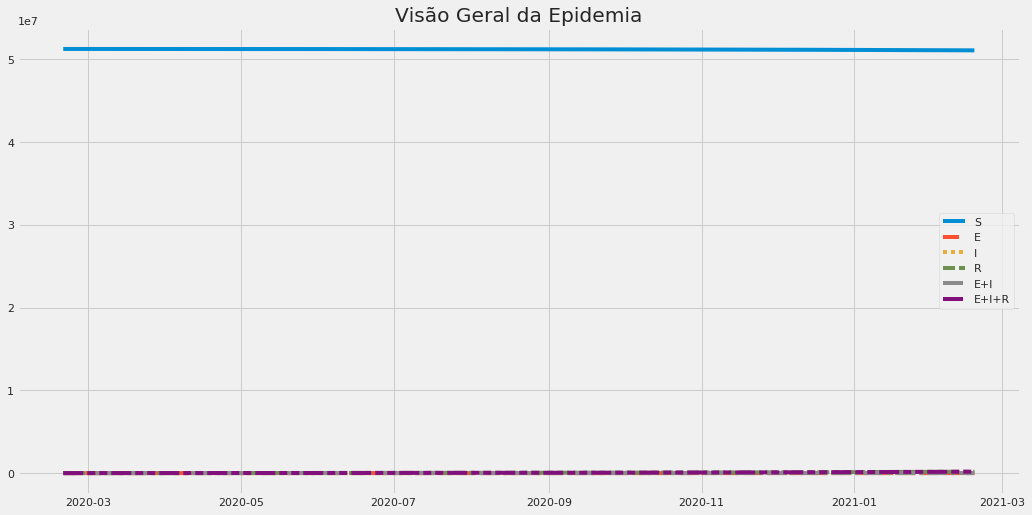

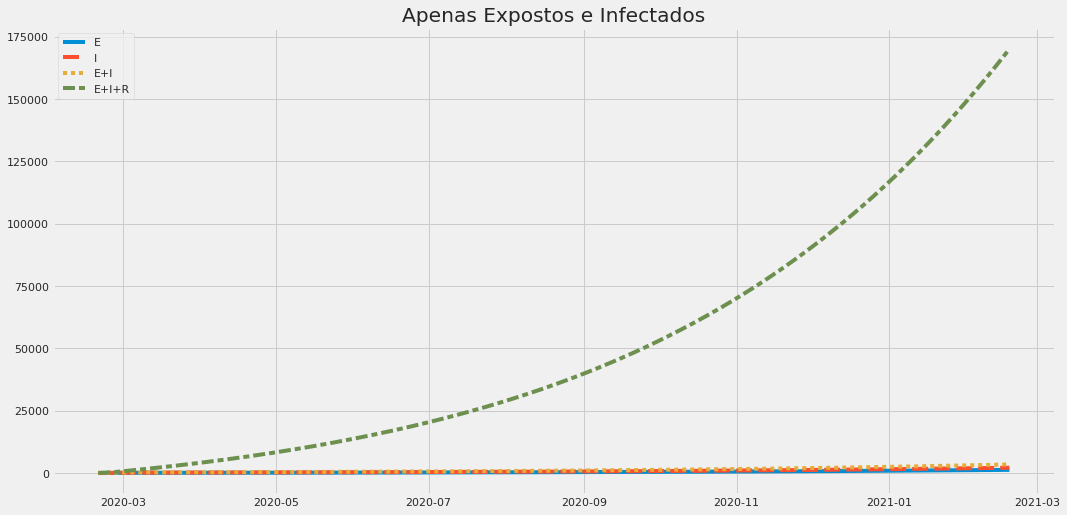

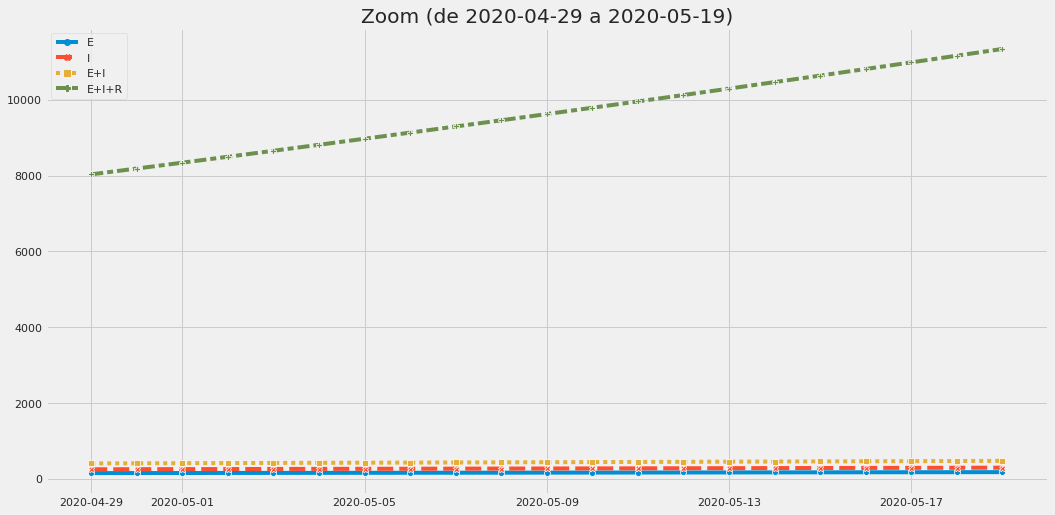

<Figure size 1152x576 with 0 Axes>

In [47]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta,
                                          r_delta_func=r_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_on='2020-04-29', zoom_length=20, file_name='dynamic')

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

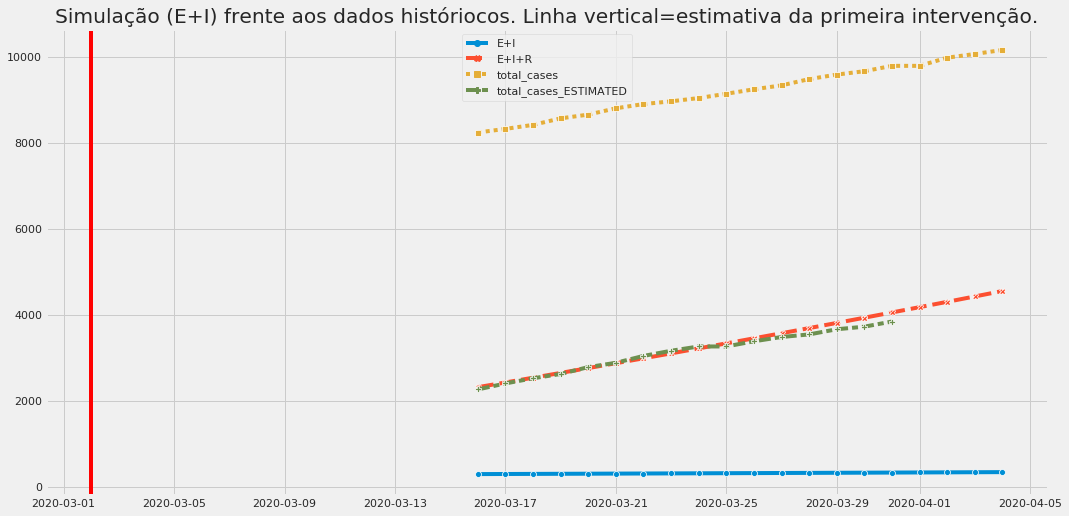

In [48]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=3)
df_simulation_mitigated_vs_real = pd.concat([df_simulation_mitigation_data, df_data_target], axis=1)
ax = sns.lineplot(data=df_simulation_mitigated_vs_real[['E+I','E+I+R', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

ax.set_title(f'Simulação (E+I) frente aos dados históriocos. Linha vertical=estimativa da primeira intervenção.')
intervention_date_1 = epidemic_start_date + pd.DateOffset(days=int(best['duration_1']))
plt.axvline(intervention_date_1, color='red')

ax.figure.savefig(results_folder + 'seir_dynamic_fit_zoom' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Finalmente, comparemos os casos com e sem mitigação.

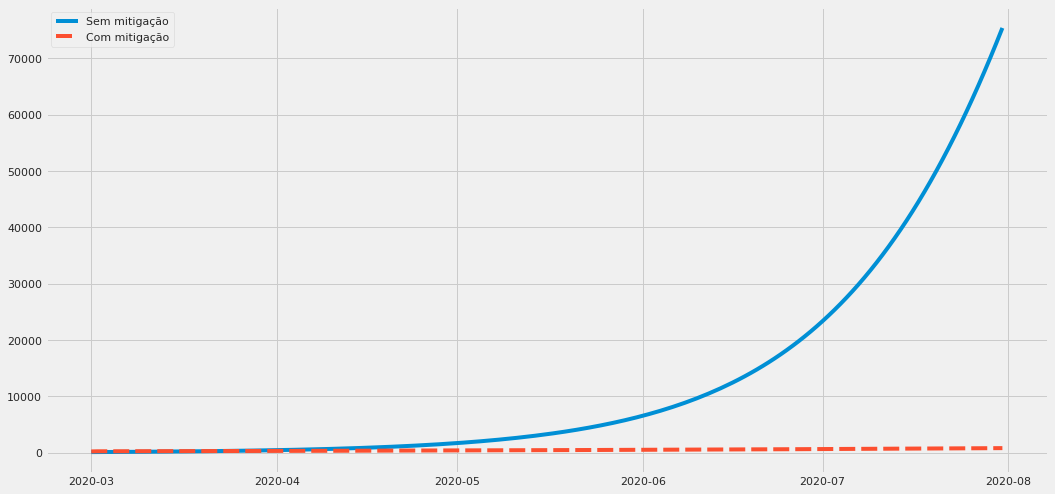

In [49]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['E+I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['E+I'].rename('Com mitigação')], axis=1)['2020-03':'2020-07'])

ax.figure.savefig(results_folder + 'seir_constant_vs_dynamic' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [50]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_dynamic_model_output.{target_location.lower()}.csv')